In [3]:
import os
import tqdm
import json
import logging
import numpy as np
import boxing_gym.envs.location_finding
import boxing_gym.envs.hyperbolic_temporal_discount
import boxing_gym.envs.death_process
import boxing_gym.envs.irt
import boxing_gym.envs.survival_analysis
import boxing_gym.envs.peregrines
import boxing_gym.envs.dugongs
import boxing_gym.envs.lotka_volterra
import boxing_gym.envs.moral_machines
import boxing_gym.envs.emotion
#import rat_tumor

ModuleNotFoundError: No module named 'boxing_gym'

In [4]:
results_dir = "/sailhome/agam/boxing-gym/results/"
exp = "oed"
# env = "hyperbolic_temporal_discount"
env = "location_finding"
# env = "death_process"
# env = "irt"
# env = "dugongs"
# env = "survival"
# env = "peregrines"
# env = "morals"
# env = "emotion"
# env = "lotka_volterra"
goal = "direct"
model = 'qwen2.5-32b-instruct' #'OpenThinker-32B' #"claude-3-7-sonnet-20250219" #  #'qwen2.5-3b-instruct' ##
box = False
seeds = [1,2,3,4,5] 

In [51]:
nametoenv = {    
    "location_finding": boxing_gym.envs.location_finding.Signal,
    "hyperbolic_temporal_discount": boxing_gym.envs.hyperbolic_temporal_discount.TemporalDiscount,
    "death_process": boxing_gym.envs.death_process.DeathProcess,
    "irt": boxing_gym.envs.irt.IRT,
    "survival": boxing_gym.envs.survival_analysis.SurvivalAnalysis,
    "dugongs": boxing_gym.envs.dugongs.Dugongs,
    "peregrines": boxing_gym.envs.peregrines.Peregrines,
    "morals": boxing_gym.envs.moral_machines.MoralMachine,
    "emotion": boxing_gym.envs.emotion.EmotionFromOutcome,
    "lotka_volterra": boxing_gym.envs.lotka_volterra.LotkaVolterra,
    #"rat_tumor": boxing_gym.envs.rat_tumor.RatTumorModel
}
nameenvtogoal = {
    ("hyperbolic_temporal_discount", "direct"): boxing_gym.envs.hyperbolic_temporal_discount.DirectGoal,
    ("hyperbolic_temporal_discount", "discount"): boxing_gym.envs.hyperbolic_temporal_discount.DiscountGoal,
    ("hyperbolic_temporal_discount", "direct_discovery"): boxing_gym.envs.hyperbolic_temporal_discount.DirectGoalNaive,
    ("location_finding", "direct"): boxing_gym.envs.location_finding.DirectGoal,
    ("location_finding", "source"): boxing_gym.envs.location_finding.SourceGoal,
    ("location_finding", "direct_discovery"): boxing_gym.envs.location_finding.DirectGoalNaive,
    ("death_process", "direct"): boxing_gym.envs.death_process.DirectDeath,
    ("death_process", "direct_discovery"): boxing_gym.envs.death_process.DirectDeathNaive,
    ("death_process", "infection"): boxing_gym.envs.death_process.InfectionRate,
    ("irt", "direct"): boxing_gym.envs.irt.DirectCorrectness,
    ("irt", "direct_discovery"): boxing_gym.envs.irt.DirectCorrectnessNaive,
    ("irt", "best_student"): boxing_gym.envs.irt.BestStudent,
    ("irt", "difficult_question"): boxing_gym.envs.irt.DifficultQuestion,
    ("irt", "discriminate_question"): boxing_gym.envs.irt.DiscriminatingQuestion,
    ("survival", "direct"): boxing_gym.envs.survival_analysis.DirectGoal,
    ("survival", "direct_discovery"): boxing_gym.envs.survival_analysis.DirectGoalNaive,
    ("dugongs", "direct"): boxing_gym.envs.dugongs.DirectGoal,
    ("dugongs", "direct_discovery"): boxing_gym.envs.dugongs.DirectGoalNaive,
    ("peregrines", "direct"): boxing_gym.envs.peregrines.DirectGoal,
    ("peregrines", "direct_discovery"): boxing_gym.envs.peregrines.DirectGoalNaive,
    ("emotion", "direct"): boxing_gym.envs.emotion.DirectEmotionPrediction,
    ("emotion", "direct_discovery"): boxing_gym.envs.emotion.DirectEmotionNaive,
    ("morals", "direct"): boxing_gym.envs.moral_machines.DirectPrediction,
    ("morals", "direct_discovery"): boxing_gym.envs.moral_machines.DirectPredictionNaive,
    ("lotka_volterra", "direct"): boxing_gym.envs.lotka_volterra.DirectGoal,
    ("lotka_volterra", "direct_discovery"): boxing_gym.envs.lotka_volterra.DirectGoalNaive,
    # ("rat_tumor", "direct"): boxing_gym.envs.rat_tumor.DirectGoal,
    # ("rat_tumor", "direct_discovery"): boxing_gym.envs.rat_tumor.DirectGoalNaive
}

In [52]:
environ = nametoenv[env]()
goaln = nameenvtogoal[env, goal](environ)
try:
    norm_mu = goaln.norm_mu
    norm_sigma = goaln.norm_sigma
except:
    norm_mu = 0
    norm_sigma = 1
    
print(f"norm_mu: {norm_mu}, norm_sigma: {norm_sigma}")

norm_mu: 12.59, norm_sigma: 38.03


In [53]:
files = [os.path.join(results_dir, env, f"{goal}_{model}_{exp}_True_{seed}.json") for seed in seeds]
files_no_prior = [os.path.join(results_dir, env, f"{goal}_{model}_{exp}_False_{seed}_critic=True.json") for seed in seeds]
files_no_prior = [os.path.join(results_dir, env, f"{goal}_{model}_{exp}_False_{seed}.json") for seed in seeds]
regret_files = [os.path.join(results_dir, env, f"regret_{goal}_{model}_{exp}_True_{seed}.json") for seed in seeds]
regret_files_no_prior = [os.path.join(results_dir, env, f"regret_{goal}_{model}_{exp}_False_{seed}.json") for seed in seeds]
# read files for box now
files_box = [os.path.join(results_dir, env, f"{goal}_{model}-boxloop_{exp}_True_{seed}.json") for seed in seeds]
#files_no_prior_box = [os.path.join(results_dir, env, f"{goal}_{model}-boxloop_{exp}_False_{seed}.json") for seed in seeds]
files_no_prior_box = [os.path.join(results_dir, env, f"{goal}_{model}_{exp}_False_{seed}_critic=True.json") for seed in seeds]
regret_files_box = [os.path.join(results_dir, env, f"regret_{goal}_{model}-boxloop_{exp}_True_{seed}.json") for seed in seeds]
regret_files_no_prior_box = [os.path.join(results_dir, env, f"regret_{goal}_{model}-boxloop_{exp}_False_{seed}.json") for seed in seeds]

In [54]:
data = []
for file in files:
    print(file)
    with open(file, "r") as f:
        data.append(json.load(f))
data_no_prior = []
for file in files_no_prior:
    if not os.path.exists(file):
        continue
    print(file)
    with open(file, "r") as f:
        data_no_prior.append(json.load(f))
regrets = []
for file in regret_files:
    if not os.path.exists(file):
        continue

    print(file)
    with open(file, "r") as f:
        regrets.append(json.load(f))
regrets_no_prior = []
for file in regret_files_no_prior:
    if not os.path.exists(file):
        continue
    print(file)
    with open(file, "r") as f:
        regrets_no_prior.append(json.load(f))

# read files for box now
data_box = []
for file in files_box:
    if not os.path.exists(file):
        continue
    print(file)
    with open(file, "r") as f:
        data_box.append(json.load(f))
data_no_prior_box = []
for file in files_no_prior_box:
    if not os.path.exists(file):
        continue
    print(file)
    with open(file, "r") as f:
        data_no_prior_box.append(json.load(f))
regrets_box = []
for file in regret_files_box:
    if not os.path.exists(file):
        continue

    print(file)
    with open(file, "r") as f:
        regrets_box.append(json.load(f))
regrets_no_prior_box = []
for file in regret_files_no_prior_box:
    if not os.path.exists(file):
        continue
    print(file)
    with open(file, "r") as f:
        regrets_no_prior_box.append(json.load(f))


/sailhome/agam/boxing-gym/results/location_finding/direct_qwen2.5-32b-instruct_oed_True_1.json
/sailhome/agam/boxing-gym/results/location_finding/direct_qwen2.5-32b-instruct_oed_True_2.json
/sailhome/agam/boxing-gym/results/location_finding/direct_qwen2.5-32b-instruct_oed_True_3.json
/sailhome/agam/boxing-gym/results/location_finding/direct_qwen2.5-32b-instruct_oed_True_4.json
/sailhome/agam/boxing-gym/results/location_finding/direct_qwen2.5-32b-instruct_oed_True_5.json
/sailhome/agam/boxing-gym/results/location_finding/direct_qwen2.5-32b-instruct_oed_False_1.json
/sailhome/agam/boxing-gym/results/location_finding/direct_qwen2.5-32b-instruct_oed_False_2.json
/sailhome/agam/boxing-gym/results/location_finding/direct_qwen2.5-32b-instruct_oed_False_3.json
/sailhome/agam/boxing-gym/results/location_finding/direct_qwen2.5-32b-instruct_oed_False_4.json
/sailhome/agam/boxing-gym/results/location_finding/direct_qwen2.5-32b-instruct_oed_False_5.json
/sailhome/agam/boxing-gym/results/location_fi

In [55]:
print(len(data[0]['data']['results'][0]))
print(data[0]['data']['results'][0][0])
print(data[0]['data']['results'][0][1])
print(data[0]['data']['results'][0][2])
print(data[0]['data']['results'][0][3])
mse = (float(data[0]['data']['results'][0][3][0]) - data[0]['data']['results'][0][2][0])**2
print(mse)
print(data[0]['data']['results'][0][0])
# print(data[1]['data']['results'][0][0])
# print(data[2]['data']['results'][0][0])
# print(data[3]['data']['results'][0][0])
# print(data[4]['data']['results'][0][0])


# mean = data[0]['data']['results'][0][0][0] + data[1]['data']['results'][0][0][0] + data[2]['data']['results'][0][0][0] + data[3]['data']['results'][0][0][0] + data[4]['data']['results'][0][0][0]
# mean /= 5
# print(mean)

# (mean, std), questions, gts, predictions
# print(regrets[0].keys())


4
[22.095579260483085, 62.47293332229573]
['You cannot make observations now. Make assumptions and provide your best guess to the following query.\n\nPredict the intensity at the following location: [-0.38291387  0.39613405]. \nWhen asked to answer a question about the environment, respond in the format specified below. Make assumptions about the environment and provide your best guess. Answer up to two decimal places.\nHere is an example.\n<thought> your thought </thought>\n<answer>1</answer>\n', 'You cannot make observations now. Make assumptions and provide your best guess to the following query.\n\nPredict the intensity at the following location: [-0.98008558  0.41674432]. \nWhen asked to answer a question about the environment, respond in the format specified below. Make assumptions about the environment and provide your best guess. Answer up to two decimal places.\nHere is an example.\n<thought> your thought </thought>\n<answer>1</answer>\n', 'You cannot make observations now. Ma

In [56]:
import numpy as np
observations = [d['data']['observations'] for d in data]
observations_no_prior = [d['data']['observations'] for d in data_no_prior]
box_observations = [d['data']['observations'] for d in data_box]
box_observations_no_prior = [d['data']['observations'] for d in data_no_prior_box]

successes = [d['data']['successes'] for d in data]
successes_no_prior = [d['data']['successes'] for d in data_no_prior]
box_successes = [d['data']['successes'] for d in data_box]
box_successes_no_prior = [d['data']['successes'] for d in data_no_prior_box]

errs, stds = [], []
for d in data:
    errs.append([])
    stds.append([])
    for r in d['data']['results']: 
        errs[-1].append(r[0][0])
        stds[-1].append(r[0][1])

box_errs, box_stds = [], []
for d in data_box:
    box_errs.append([])
    box_stds.append([])
    for r in d['data']['results']: 
        box_errs[-1].append(r[0][0])
        box_stds[-1].append(r[0][1])

errs_no_prior, stds_no_prior = [], []
for d in data_no_prior:
    errs_no_prior.append([])
    stds_no_prior.append([])
    for r in d['data']['results']: 
        errs_no_prior[-1].append(r[0][0])
        stds_no_prior[-1].append(r[0][1])

box_errs_no_prior, box_stds_no_prior = [], []
for d in data_no_prior_box:
    box_errs_no_prior.append([])
    box_stds_no_prior.append([])
    for r in d['data']['results']: 
        box_errs_no_prior[-1].append(r[0][0])
        box_stds_no_prior[-1].append(r[0][1])

errs = np.array(errs)
print(errs)
stds = np.array(stds)
box_errs = np.array(box_errs)
box_stds = np.array(box_stds)
errs_no_prior = np.array(errs_no_prior)
print(errs_no_prior)
stds_no_prior = np.array(stds_no_prior)
box_errs_no_prior = np.array(box_errs_no_prior)
box_stds_no_prior = np.array(box_stds_no_prior)

if env == "location_finding" and "direct" in goal:
    # clip
    errs = np.clip(errs, 0, 500)
    #errs = np.clip(errs, 0, 10000)
    box_errs = np.clip(box_errs, 0, 10000)
    errs_no_prior = np.clip(errs_no_prior, 0, 500)
    box_errs_no_prior = np.clip(box_errs_no_prior, 0, 10000)

# normalize
errs = (errs - norm_mu) / norm_sigma
box_errs = (box_errs - norm_mu) / norm_sigma
errs_no_prior = (errs_no_prior - norm_mu) / norm_sigma
box_errs_no_prior = (box_errs_no_prior - norm_mu) / norm_sigma

if env == "irt":#  and not box:
    #TODO: hacky fix for irt
    eigs, eigs_no_prior, eig_regrets, eigregrets_no_prior = [], [], [], []
    for a, d in enumerate(regrets):
        eigs.append([])
        eig_regrets.append([])
        for b, r in enumerate(d['eigs']):
            if successes[a][b]:
                eigs[-1].append(r)
                eig_regrets[-1].append(d['eigs_regret'][b])

        eigs[-1] = eigs[-1][:9]
        eig_regrets[-1] = eig_regrets[-1][:9]
        
    for a, d in enumerate(regrets_no_prior):
        eigs_no_prior.append([])
        eigregrets_no_prior.append([])
        for b, r in enumerate(d['eigs']):
            if successes_no_prior[a][b]:
                eigs_no_prior[-1].append(r)
                eigregrets_no_prior[-1].append(d['eigs_regret'][b])
        eigs_no_prior[-1] = eigs_no_prior[-1][:9]
        eigregrets_no_prior[-1] = eigregrets_no_prior[-1][:9]
if env == "irt":# and box:
    #TODO: hacky fix for irt
    box_eigs, box_eigs_no_prior, box_eig_regrets, box_eigregrets_no_prior = [], [], [], []
    for a, d in enumerate(regrets_box):
        box_eigs.append([])
        box_eig_regrets.append([])
        for b, r in enumerate(d['eigs']):
            if box_successes[a][b]:
                box_eigs[-1].append(r)
                box_eig_regrets[-1].append(d['eigs_regret'][b])

        box_eigs[-1] = box_eig_regrets[-1][:9]
        box_eig_regrets[-1] = box_eig_regrets[-1][:9]
        
    for a, d in enumerate(regrets_no_prior_box):
        box_eigs_no_prior.append([])
        box_eigregrets_no_prior.append([])
        for b, r in enumerate(d['eigs']):
            if box_successes_no_prior[a][b]:
                box_eigs_no_prior[-1].append(r)
                box_eigregrets_no_prior[-1].append(d['eigs_regret'][b])
        box_eigs_no_prior[-1] = box_eigs_no_prior[-1][:9]
        box_eigregrets_no_prior[-1] = box_eigregrets_no_prior[-1][:9]
else:
    try:
        eigs = [np.array(d['eigs']) for d in regrets]
        eigs_no_prior = [np.array(d['eigs']) for d in regrets_no_prior]
        box_eigs = [np.array(d['eigs']) for d in regrets_box]
        box_eigs_no_prior = [np.array(d['eigs']) for d in regrets_no_prior_box]
    except:
        eigs = []
        eigs_no_prior = []
        box_eigs = []
        box_eigs_no_prior = []
    eig_regrets = [np.array(d['eigs_regret']) for d in regrets]
    eigregrets_no_prior = [np.array(d['eigs_regret']) for d in regrets_no_prior]
    box_eig_regrets = [np.array(d['eigs_regret']) for d in regrets_box]
    box_eigregrets_no_prior = [np.array(d['eigs_regret']) for d in regrets_no_prior_box]
print([len(e) for e in eigs])
print([len(e) for e in eigs_no_prior])
print([len(e) for e in eig_regrets])
print([len(e) for e in eigregrets_no_prior])
print([len(e) for e in box_eigs])
print([len(e) for e in box_eigs_no_prior])
print([len(e) for e in box_eig_regrets])
print([len(e) for e in box_eigregrets_no_prior])

if env == "hyperbolic_temporal_discount" and "direct" in goal:
    errs = 1 - errs
    errs_no_prior = 1 - errs_no_prior
    box_errs = 1 - box_errs
    box_errs_no_prior = 1 - box_errs_no_prior
# if env == "peregrines":
#     errs = errs ** 0.5
#     errs_no_prior = errs_no_prior ** 0.5 
if env == "survival":
    errs = 1 - errs
    errs_no_prior = 1 - errs_no_prior
    box_errs = 1 - box_errs
    box_errs_no_prior = 1 - box_errs_no_prior
if env == "morals":
    print("removing")
    errs = 1 - errs
    box_errs = 1 - box_errs
if env == "location_finding":
    if "source" in goal:
        # clip
        eig_regrets = np.clip(eig_regrets, 0, 50000)
        eig_regrets/=1000
        box_eig_regrets = np.clip(box_eig_regrets, 0, 50000)
        box_eig_regrets/=1000
    elif "direct" in goal:
        eig_regrets = np.clip(eig_regrets, 0, 50000)
        eig_regrets/=1000
        box_eig_regrets = np.clip(box_eig_regrets, 0, 50000)
        box_eig_regrets/=1000
        eigregrets_no_prior = np.clip(eigregrets_no_prior, 0, 50000)
        box_eigregrets_no_prior = np.clip(box_eigregrets_no_prior, 0, 50000)
        eigregrets_no_prior/=1000
        box_eigregrets_no_prior/=1000
    
print(errs)
mean_score = np.mean(errs, axis=0)
ci_95 = 1.96 * np.std(errs, axis=0) / np.sqrt(len(errs))
box_mean_score = np.mean(box_errs, axis=0)
box_ci_95 = 1.96 * np.std(box_errs, axis=0) / np.sqrt(len(box_errs))
mean_score_no_prior = None
ci_95_no_prior = None
if len(errs_no_prior) > 0:
    mean_score_no_prior = np.mean(errs_no_prior, axis=0)
    ci_95_no_prior = 1.96 * np.std(errs_no_prior, axis=0) / np.sqrt(len(errs_no_prior))
    box_mean_score_no_prior = np.mean(box_errs_no_prior, axis=0)
    box_ci_95_no_prior = 1.96 * np.std(box_errs_no_prior, axis=0) / np.sqrt(len(box_errs_no_prior))

print(mean_score[0])
print(ci_95[0])
print(mean_score_no_prior[0])
print(ci_95_no_prior[0])

[[2.20955793e+01 1.72098757e+01 1.72790069e+01 2.30729597e+01
  2.24039516e+01 2.53973273e+01]
 [1.26908288e+01 1.02092000e+01 5.40151453e+00 6.39892425e+01
  1.96172750e+01 9.77350752e+00]
 [1.52621137e+00 3.22940553e-01 1.41738487e+00 7.79638221e-01
  3.25614002e-01 6.40307916e-01]
 [5.06128001e+03 4.97189241e+03 5.00734004e+03 5.04592388e+03
  5.02753139e+03 4.95928303e+03]
 [1.39103280e+00 1.10659280e+00 2.41075080e-01 1.00842010e+01
  5.18170878e-01 3.94314765e+03]]
[[7.26813095e+01 1.05869020e+05 2.83766717e+04 1.96585788e+04
  1.75829081e+04 9.04785453e+03]
 [3.36706007e+01 2.68383813e+01 1.67919483e+01 7.86930747e+00
  7.95816981e+00 8.10388503e+00]
 [2.61099965e+00 2.86478256e+01 4.94754839e+00 2.79262488e+00
  2.34625331e+00 9.05361131e+00]
 [4.84628730e+00 2.18556498e+00 2.57187040e+02 2.13537672e+01
  1.11263189e+01 2.23694548e+01]
 [2.14316923e+01 1.60278949e+01 4.31773226e+00 5.79152185e+00
  5.51837426e+00 6.87593078e+00]]
[10, 10, 10, 10, 10]
[10, 10, 10, 10, 10]
[10, 1

In [57]:
import os
os.makedirs('./plots', exist_ok=True)

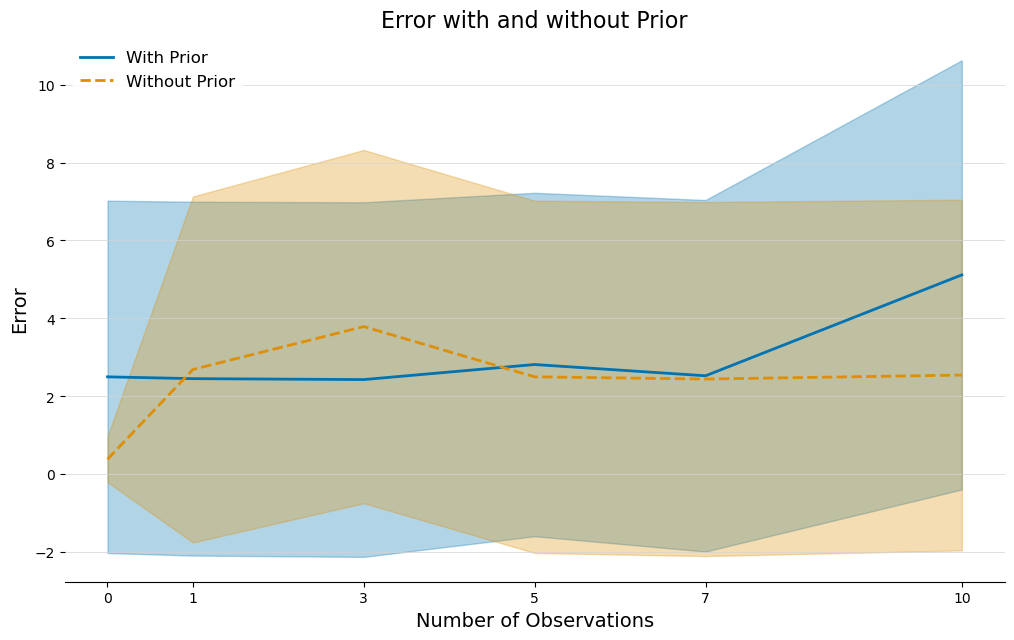

In [58]:
from plot_utils import plot_lines, plot_lines2

exp_list = [0, 1, 3, 5, 7, 10]
box_exp_list = [0, 5, 10]

save_path = os.path.join('./plots', f"both_{env}_{goal}_{model}_{exp}_oed_error.png")
# plot_lines2(exp_list, mean_score, ci_95, mean_score_no_prior, ci_95_no_prior, 
#         "w/ Prior gpt-4o", "w/o Prior gpt-4o", 
#         box_exp_list, box_mean_score, box_ci_95, box_mean_score_no_prior, box_ci_95_no_prior, 
#         "w/ Prior Box's Apprentice", "w/o Prior Box's Apprentice", 
#         "", "", "", save_path, legend_loc="upper right")

# print(len(mean_score), len(mean_score_no_prior))
# print(len(exp_list))
plot_lines(exp_list, mean_score, ci_95, mean_score_no_prior, ci_95_no_prior, "With Prior", "Without Prior", "Number of Observations", "Error", "Error with and without Prior", save_path)
# print(mean_score)


In [59]:
# print len of queries in data
print(len(data[0]['data']['queries']))

10


In [60]:
print(np.array(eigs).shape)
print(np.array(eigs_no_prior).shape)
print(np.array(eig_regrets).shape)
print(np.array(eigregrets_no_prior).shape)

(5, 10)
(5, 10)
(5, 10)
(5, 10)


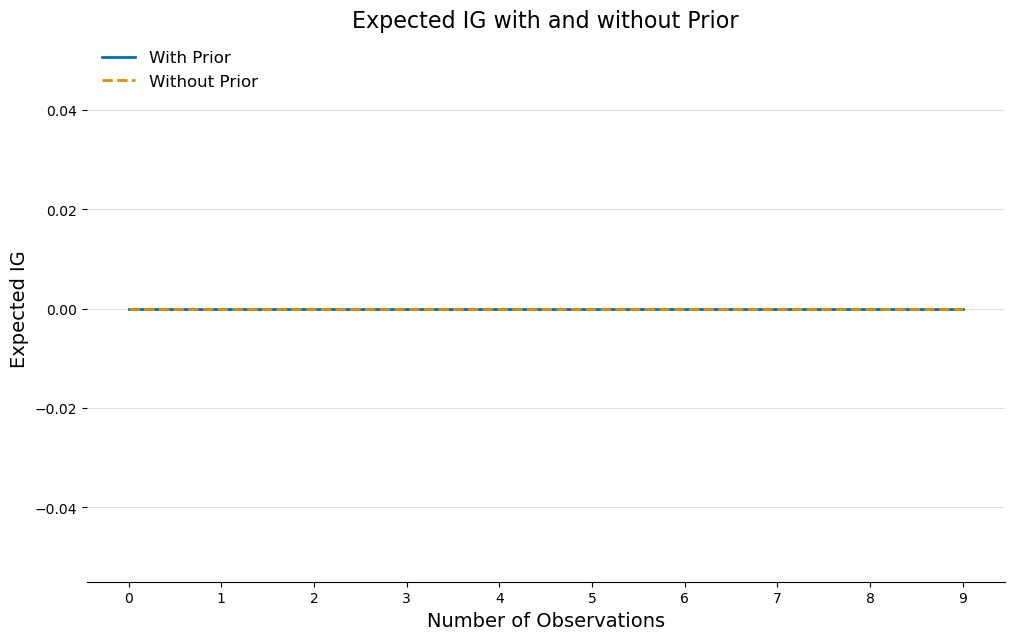

In [61]:
if env == "irt":
    #TODO: hacky fix for irt
    observation_nums = list(range(9))
else:
    observation_nums = list(range(10))
eigs = np.array(eigs)
eigs_no_prior = np.array(eigs_no_prior)

# clip eigs at 100, -100
# eigs = np.clip(eigs, -100, 100)
# eigs_no_prior = np.clip(eigs_no_prior, -100, 100)
if len(eigs) > 0:
    mean_eigs = np.mean(eigs, axis=0)
    ci_95_eigs = 1.96 * np.std(eigs, axis=0) / np.sqrt(len(eigs))
    if len(eigs_no_prior) > 0:
        mean_eigs_no_prior = np.mean(eigs_no_prior, axis=0)
        ci_95_eigs_no_prior = 1.96 * np.std(eigs_no_prior, axis=0) / np.sqrt(len(eigs_no_prior))
    else:
        mean_eigs_no_prior = None
        ci_95_eigs_no_prior = None
    save_path = os.path.join('./plots', f"{env}_{goal}_{model}_{exp}_oed_eigs.png")
    plot_lines(observation_nums, mean_eigs, ci_95_eigs, mean_eigs_no_prior, ci_95_eigs_no_prior, "With Prior", "Without Prior", "Number of Observations", "Expected IG", "Expected IG with and without Prior", save_path)

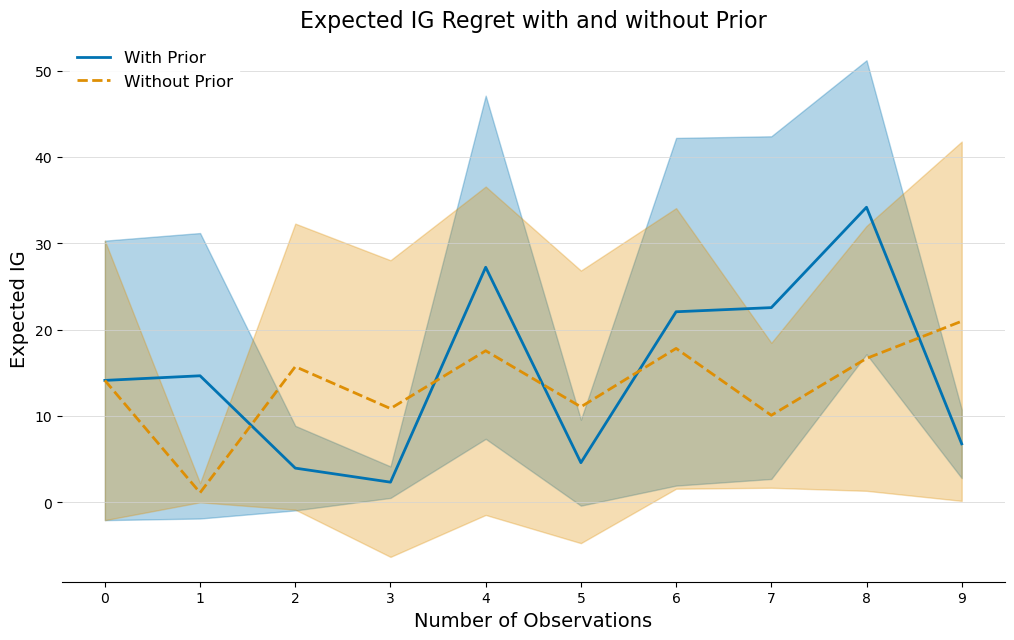

In [62]:
# regret_prior = [regret['eigs_regret'] for regret in regrets]
# regret_no_prior = [regret['eigs_regret'] for regret in regrets_no_prior]
regret_prior = eig_regrets
regret_no_prior = eigregrets_no_prior
box_regret_prior = box_eig_regrets
box_regret_no_prior = box_eigregrets_no_prior
if env == "irt":
    #TODO: hacky fix for irt
    observation_nums = list(range(9))
else:
    observation_nums = list(range(10))

mean_regret = None
box_mean_regret = None
if len(regret_prior) > 0:
    mean_regret = np.mean(regret_prior, axis=0)
    box_mean_regret = np.mean(box_regret_prior, axis=0)
    ci_95_regret = 1.96 * np.std(regret_prior, axis=0) / np.sqrt(len(regret_prior))
    box_ci_95_regret = 1.96 * np.std(box_regret_prior, axis=0) / np.sqrt(len(box_regret_prior))
    mean_regret_no_prior = None
    box_mean_regret_no_prior = None
    if len(regret_no_prior) > 0:
        mean_regret_no_prior = np.mean(regret_no_prior, axis=0)
        ci_95_regret_no_prior = 1.96 * np.std(regret_no_prior, axis=0) / np.sqrt(len(regret_no_prior))
        box_mean_regret_no_prior = np.mean(box_regret_no_prior, axis=0)
        box_ci_95_regret_no_prior = 1.96 * np.std(box_regret_no_prior, axis=0) / np.sqrt(len(box_regret_no_prior))
    else:
        mean_regret_no_prior = None
        ci_95_regret_no_prior = None
        box_mean_regret_no_prior = None
        box_ci_95_regret_no_prior = None

    save_path = os.path.join('./plots', f"both_{env}_{goal}_{model}_{exp}_oed_regret.png")
    plot_lines(observation_nums, mean_regret, ci_95_regret, mean_regret_no_prior, ci_95_regret_no_prior, "With Prior", "Without Prior", "Number of Observations", "Expected IG", "Expected IG Regret with and without Prior", save_path)

    # plot_lines2(observation_nums, mean_regret, ci_95_regret, mean_regret_no_prior, ci_95_regret_no_prior, 
    #         "w/ Prior gpt-4o", "w/o Prior gpt-4o", 
    #         observation_nums, box_mean_regret, box_ci_95_regret, box_mean_regret_no_prior, box_ci_95_regret_no_prior,
    #         "w/ Prior Box's Apprentice", "w/o Prior Box's Apprentice", 
    #         "", "", "", save_path, legend_loc="lower left")

In [63]:
print(mean_score[-1])

5.116282633278383


In [64]:
# Metrics to report in the table:

print(f"{'Metric':<40} &  \\\\")
# 3. Mean error at 0 observations
mean_error_0 = mean_score[0]
ci_95_error_0 = ci_95[0]
print(f"{'Prior Mean Error at 0 Observations':<40} & {mean_error_0} ({ci_95_error_0})")
# 4. Mean error at 0 observations without prior
if mean_score_no_prior is not None:
    mean_error_0_no_prior = mean_score_no_prior[0]
    ci_95_error_0_no_prior = ci_95_no_prior[0]
    print(f"{'No Prior Mean Error at 0 Observations':<40} & {mean_error_0_no_prior} ({ci_95_error_0_no_prior}) \\\\")
# 1. Mean error at 10 observations
mean_error_10 = mean_score[-1]
ci_95_error_10 = ci_95[-1]
print(f"{'Prior Mean Error at 10 Observations':<40} & {mean_error_10} ({ci_95_error_10})") 
# 2. Mean error at 10 observations without prior
if mean_score_no_prior is not None:
    mean_error_10_no_prior = mean_score_no_prior[-1]
    ci_95_error_10_no_prior = ci_95_no_prior[-1]
    print(f"{'No Prior Mean Error at 10 Observations':<40} & {mean_error_10_no_prior} ({ci_95_error_10_no_prior}) \\\\")

# 5. Mean regret over all observations
if mean_regret is not None:
    mean_regret_all = np.mean(mean_regret)
    ci_95_regret_all = np.mean(ci_95_regret)
    print(f"{'Mean Regret over all Observations':<40} & {mean_regret_all} ({ci_95_regret_all})")
# 6. Mean regret over all observations without prior
if mean_regret_no_prior is not None:
    mean_regret_all_no_prior = np.mean(mean_regret_no_prior)
    ci_95_regret_all_no_prior = np.mean(ci_95_regret_no_prior)
    print(f"{'No Prior Mean Regret over all Observations':<40} & {mean_regret_all_no_prior} ({ci_95_regret_all_no_prior}) \\\\")

# Print the table




Metric                                   &  \\
Prior Mean Error at 0 Observations       & 2.4967323284764626 (4.526320941763308)
No Prior Mean Error at 0 Observations    & 0.3801782249427458 (0.5874352153217935) \\
Prior Mean Error at 10 Observations      & 5.116282633278383 (5.51396764644869)
No Prior Mean Error at 10 Observations   & 2.542481630027474 (4.5046218214252285) \\
Mean Regret over all Observations        & 15.232768755033401 (12.526238722690096)
No Prior Mean Regret over all Observations & 13.584175393628588 (14.661963964221815) \\


In [65]:
print(np.mean(box_mean_regret_no_prior))

nan


In [66]:
# Metrics to report in the table:

print(f"{'Metric':<40} &  \\\\")
# 3. Mean error at 0 observations
mean_error_0 = box_mean_score[0]
ci_95_error_0 = box_ci_95[0]
print(f"{'Mean Error at 0 Observations':<40} & {mean_error_0} ({ci_95_error_0})")
# 4. Mean error at 0 observations without prior
if box_mean_score_no_prior is not None:
    mean_error_0_no_prior = box_mean_score_no_prior[0]
    ci_95_error_0_no_prior = box_ci_95_no_prior[0]
    print(f"{'No Prior Mean Error at 0 Observations':<40} & {mean_error_0_no_prior} ({ci_95_error_0_no_prior}) \\\\")
# 1. Mean error at 10 observations
mean_error_10 = box_mean_score[-1]
ci_95_error_10 = box_ci_95[-1]
print(f"{'Prior Mean Error at 10 Observations':<40} & {mean_error_10} ({ci_95_error_10})") 
# 2. Mean error at 10 observations without prior
if box_mean_score_no_prior is not None:
    mean_error_10_no_prior = box_mean_score_no_prior[-1]
    ci_95_error_10_no_prior = box_ci_95_no_prior[-1]
    print(f"{'No Prior Mean Error at 10 Observations':<40} & {mean_error_10_no_prior} ({ci_95_error_10_no_prior}) \\\\")

# # 5. Mean regret over all observations
if mean_regret is not None:
    mean_regret_all = np.mean(mean_regret)
    ci_95_regret_all = np.mean(ci_95_regret)
    print(f"{'Mean Regret over all Observations':<40} & {mean_regret_all} ({ci_95_regret_all})")
# 6. Mean regret over all observations without prior
if mean_regret_no_prior is not None:
    mean_regret_all_no_prior = np.mean(mean_regret_no_prior)
    ci_95_regret_all_no_prior = np.mean(ci_95_regret_no_prior)
    print(f"{'No Prior Mean Regret over all Observations':<40} & {mean_regret_all_no_prior} ({ci_95_regret_all_no_prior}) \\\\")

# Print the table




Metric                                   &  \\


IndexError: invalid index to scalar variable.

In [68]:
import os
import json
import numpy as np
import pandas as pd
import boxing_gym.envs.location_finding
import boxing_gym.envs.hyperbolic_temporal_discount
import boxing_gym.envs.death_process
import boxing_gym.envs.irt
import boxing_gym.envs.survival_analysis
import boxing_gym.envs.peregrines
import boxing_gym.envs.dugongs
import boxing_gym.envs.lotka_volterra
import boxing_gym.envs.moral_machines
import boxing_gym.envs.emotion

# Common parameters
results_dir = "/sailhome/agam/boxing-gym/results/"
exp = "oed"
model = "claude-3-7-sonnet-20250219" #'gpt-4o' #'OpenThinker-7B'  # Base model
seeds = [1, 2, 3, 4, 5]
goal = "direct"  # Use direct goal for all environments

# All environments to process
environments = [
    "hyperbolic_temporal_discount",
    "location_finding",
    "death_process",
    "irt",
    "dugongs",
    "survival",
    "peregrines",
    "morals",
    "emotion",
    "lotka_volterra"
]

# Define mappings
nametoenv = {    
    "location_finding": boxing_gym.envs.location_finding.Signal,
    "hyperbolic_temporal_discount": boxing_gym.envs.hyperbolic_temporal_discount.TemporalDiscount,
    "death_process": boxing_gym.envs.death_process.DeathProcess,
    "irt": boxing_gym.envs.irt.IRT,
    "survival": boxing_gym.envs.survival_analysis.SurvivalAnalysis,
    "dugongs": boxing_gym.envs.dugongs.Dugongs,
    "peregrines": boxing_gym.envs.peregrines.Peregrines,
    "morals": boxing_gym.envs.moral_machines.MoralMachine,
    "emotion": boxing_gym.envs.emotion.EmotionFromOutcome,
    "lotka_volterra": boxing_gym.envs.lotka_volterra.LotkaVolterra,
}

nameenvtogoal = {
    ("hyperbolic_temporal_discount", "direct"): boxing_gym.envs.hyperbolic_temporal_discount.DirectGoal,
    ("location_finding", "direct"): boxing_gym.envs.location_finding.DirectGoal,
    ("death_process", "direct"): boxing_gym.envs.death_process.DirectDeath,
    ("irt", "direct"): boxing_gym.envs.irt.DirectCorrectness,
    ("survival", "direct"): boxing_gym.envs.survival_analysis.DirectGoal,
    ("dugongs", "direct"): boxing_gym.envs.dugongs.DirectGoal,
    ("peregrines", "direct"): boxing_gym.envs.peregrines.DirectGoal,
    ("emotion", "direct"): boxing_gym.envs.emotion.DirectEmotionPrediction,
    ("morals", "direct"): boxing_gym.envs.moral_machines.DirectPrediction,
    ("lotka_volterra", "direct"): boxing_gym.envs.lotka_volterra.DirectGoal,
}

# Function to process an environment
def process_environment(env, goal, model, exp, seeds, results_dir):
    print(f"\nProcessing environment: {env}")
    
    # Create environment and goal objects to get normalization parameters
    environ = nametoenv[env]()
    goaln = nameenvtogoal[(env, goal)](environ)
    
    try:
        norm_mu = goaln.norm_mu
        norm_sigma = goaln.norm_sigma
    except:
        norm_mu = 0
        norm_sigma = 1
    
    print(f"  Normalization: mu={norm_mu}, sigma={norm_sigma}")
    
    # Construct file paths
    files = [os.path.join(results_dir, env, f"{goal}_{model}_{exp}_True_{seed}.json") for seed in seeds]
    files_no_prior = [os.path.join(results_dir, env, f"{goal}_{model}_{exp}_False_{seed}.json") for seed in seeds]
    
    # Load data with prior
    data = []
    for file in files:
        if not os.path.exists(file):
            print(f"  File not found: {file}")
            continue
        with open(file, "r") as f:
            data.append(json.load(f))
    
    # Load data without prior
    data_no_prior = []
    for file in files_no_prior:
        if not os.path.exists(file):
            print(f"  File not found: {file}")
            continue
        with open(file, "r") as f:
            data_no_prior.append(json.load(f))
    
    # Extract errors and stds with prior
    errs, stds = [], []
    for d in data:
        errs.append([])
        stds.append([])
        for r in d['data']['results']: 
            errs[-1].append(r[0][0])
            stds[-1].append(r[0][1])
    
    # Extract errors and stds without prior
    errs_no_prior, stds_no_prior = [], []
    for d in data_no_prior:
        errs_no_prior.append([])
        stds_no_prior.append([])
        for r in d['data']['results']: 
            errs_no_prior[-1].append(r[0][0])
            stds_no_prior[-1].append(r[0][1])
    
    # Convert to numpy arrays
    errs = np.array(errs)
    stds = np.array(stds)
    errs_no_prior = np.array(errs_no_prior)
    stds_no_prior = np.array(stds_no_prior)
    
    # Apply environment-specific transformations
    if env == "location_finding" and "direct" in goal:
        # Clip values
        errs = np.clip(errs, 0, 500)
        errs_no_prior = np.clip(errs_no_prior, 0, 500)
    
    # Normalize
    errs = (errs - norm_mu) / norm_sigma
    errs_no_prior = (errs_no_prior - norm_mu) / norm_sigma
    
    # Environment-specific transformations
    if env == "hyperbolic_temporal_discount" and "direct" in goal:
        errs = 1 - errs
        errs_no_prior = 1 - errs_no_prior
    elif env == "survival":
        errs = 1 - errs
        errs_no_prior = 1 - errs_no_prior
    elif env == "morals":
        print("  Applying 1-minus transformation for morals")
        errs = 1 - errs
    
    # Calculate metrics
    results = {}
    
    if len(errs) > 0:
        mean_score = np.mean(errs, axis=0)
        ci_95 = 1.96 * np.std(errs, axis=0) / np.sqrt(len(errs))
        
        # Store mean error at first observation (0)
        if len(mean_score) > 0:
            results['mean_error_0'] = mean_score[0]
            results['ci_95_error_0'] = ci_95[0]
        else:
            results['mean_error_0'] = None
            results['ci_95_error_0'] = None
        
        # Store mean error at last observation (10 or last available)
        if len(mean_score) > 0:
            results['mean_error_last'] = mean_score[-1]
            results['ci_95_error_last'] = ci_95[-1]
        else:
            results['mean_error_last'] = None
            results['ci_95_error_last'] = None
    else:
        results['mean_error_0'] = None
        results['ci_95_error_0'] = None
        results['mean_error_last'] = None
        results['ci_95_error_last'] = None
    
    if len(errs_no_prior) > 0:
        mean_score_no_prior = np.mean(errs_no_prior, axis=0)
        ci_95_no_prior = 1.96 * np.std(errs_no_prior, axis=0) / np.sqrt(len(errs_no_prior))
        
        # Store mean error at first observation without prior
        if len(mean_score_no_prior) > 0:
            results['mean_error_0_no_prior'] = mean_score_no_prior[0]
            results['ci_95_error_0_no_prior'] = ci_95_no_prior[0]
        else:
            results['mean_error_0_no_prior'] = None
            results['ci_95_error_0_no_prior'] = None
        
        # Store mean error at last observation without prior
        if len(mean_score_no_prior) > 0:
            results['mean_error_last_no_prior'] = mean_score_no_prior[-1]
            results['ci_95_error_last_no_prior'] = ci_95_no_prior[-1]
        else:
            results['mean_error_last_no_prior'] = None
            results['ci_95_error_last_no_prior'] = None
    else:
        results['mean_error_0_no_prior'] = None
        results['ci_95_error_0_no_prior'] = None
        results['mean_error_last_no_prior'] = None
        results['ci_95_error_last_no_prior'] = None
    
    # Add normalization parameters to results
    results['norm_mu'] = norm_mu
    results['norm_sigma'] = norm_sigma
    
    # Store the full arrays for potential further analysis
    results['mean_score_array'] = mean_score if len(errs) > 0 else None
    results['ci_95_array'] = ci_95 if len(errs) > 0 else None
    results['mean_score_no_prior_array'] = mean_score_no_prior if len(errs_no_prior) > 0 else None
    results['ci_95_no_prior_array'] = ci_95_no_prior if len(errs_no_prior) > 0 else None
    
    return results

# Process all environments and collect results
all_results = {}
for env in environments:
    try:
        env_results = process_environment(env, goal, model, exp, seeds, results_dir)
        all_results[env] = env_results
    except Exception as e:
        print(f"Error processing environment {env}: {e}")
        all_results[env] = {
            'norm_mu': None,
            'norm_sigma': None,
            'mean_error_0': None,
            'ci_95_error_0': None,
            'mean_error_last': None,
            'ci_95_error_last': None,
            'mean_error_0_no_prior': None,
            'ci_95_error_0_no_prior': None,
            'mean_error_last_no_prior': None,
            'ci_95_error_last_no_prior': None,
            'mean_score_array': None,
            'ci_95_array': None,
            'mean_score_no_prior_array': None,
            'ci_95_no_prior_array': None
        }

# Create a DataFrame for the results
df = pd.DataFrame(columns=[
    'Environment',
    'Norm μ',
    'Norm σ',
    'Prior Error (First Obs)',
    'Prior Error (First Obs CI)',
    'Prior Error (Last Obs)',
    'Prior Error (Last Obs CI)',
    'No Prior Error (First Obs)',
    'No Prior Error (First Obs CI)',
    'No Prior Error (Last Obs)',
    'No Prior Error (Last Obs CI)'
])

# Populate the DataFrame
for env, results in all_results.items():
    new_row = pd.DataFrame({
        'Environment': [env],
        'Norm μ': [f"{results['norm_mu']:.4f}" if results['norm_mu'] is not None else "N/A"],
        'Norm σ': [f"{results['norm_sigma']:.4f}" if results['norm_sigma'] is not None else "N/A"],
        'Prior Error (First Obs)': [f"{results['mean_error_0']:.4f}" if results['mean_error_0'] is not None else "N/A"],
        'Prior Error (First Obs CI)': [f"±{results['ci_95_error_0']:.4f}" if results['ci_95_error_0'] is not None else "N/A"],
        'Prior Error (Last Obs)': [f"{results['mean_error_last']:.4f}" if results['mean_error_last'] is not None else "N/A"],
        'Prior Error (Last Obs CI)': [f"±{results['ci_95_error_last']:.4f}" if results['ci_95_error_last'] is not None else "N/A"],
        'No Prior Error (First Obs)': [f"{results['mean_error_0_no_prior']:.4f}" if results['mean_error_0_no_prior'] is not None else "N/A"],
        'No Prior Error (First Obs CI)': [f"±{results['ci_95_error_0_no_prior']:.4f}" if results['ci_95_error_0_no_prior'] is not None else "N/A"],
        'No Prior Error (Last Obs)': [f"{results['mean_error_last_no_prior']:.4f}" if results['mean_error_last_no_prior'] is not None else "N/A"],
        'No Prior Error (Last Obs CI)': [f"±{results['ci_95_error_last_no_prior']:.4f}" if results['ci_95_error_last_no_prior'] is not None else "N/A"]
    })
    df = pd.concat([df, new_row], ignore_index=True)

# Display the results
print("\nResults for all environments:")
print(df.to_string(index=False))

# Save results to CSV
output_path = os.path.join(results_dir, f"{model}_{exp}_{goal}_all_environments.csv")
df.to_csv(output_path, index=False)
print(f"\nResults saved to {output_path}")

# Print LaTeX table format
print("\nLaTeX Table Format:")
print("\\begin{tabular}{|l|c|c|c|c|}")
print("\\hline")
print("Environment & Prior Error (First) & No Prior Error (First) & Prior Error (Last) & No Prior Error (Last) \\\\")
print("\\hline")

for env, results in all_results.items():
    prior_first = f"{results['mean_error_0']:.4f} (±{results['ci_95_error_0']:.4f})" if results['mean_error_0'] is not None else "N/A"
    no_prior_first = f"{results['mean_error_0_no_prior']:.4f} (±{results['ci_95_error_0_no_prior']:.4f})" if results['mean_error_0_no_prior'] is not None else "N/A"
    prior_last = f"{results['mean_error_last']:.4f} (±{results['ci_95_error_last']:.4f})" if results['mean_error_last'] is not None else "N/A"
    no_prior_last = f"{results['mean_error_last_no_prior']:.4f} (±{results['ci_95_error_last_no_prior']:.4f})" if results['mean_error_last_no_prior'] is not None else "N/A"
    
    print(f"{env} & {prior_first} & {no_prior_first} & {prior_last} & {no_prior_last} \\\\")

print("\\hline")
print("\\end{tabular}")

# Additionally, print a summary of improvement from first to last observation
print("\nImprovement Summary (First to Last Observation):")
print("\\begin{tabular}{|l|c|c|c|}")
print("\\hline")
print("Environment & Prior Improvement & No Prior Improvement & Difference \\\\")
print("\\hline")

for env, results in all_results.items():
    if (results['mean_error_0'] is not None and results['mean_error_last'] is not None and 
        results['mean_error_0_no_prior'] is not None and results['mean_error_last_no_prior'] is not None):
        
        prior_improvement = results['mean_error_0'] - results['mean_error_last']
        no_prior_improvement = results['mean_error_0_no_prior'] - results['mean_error_last_no_prior']
        difference = prior_improvement - no_prior_improvement
        
        print(f"{env} & {prior_improvement:.4f} & {no_prior_improvement:.4f} & {difference:.4f} \\\\")
    else:
        print(f"{env} & N/A & N/A & N/A \\\\")

exp_list = [0, 1, 3, 5, 7, 10]

rows = []
for env, res in all_results.items():
    # helper to fetch value or NaN
    def safe(arr, idx):
        if arr is None or len(arr) <= idx:
            return np.nan
        return arr[idx]

    for prior_flag, arr_key, ci_key in [
        (True,  'mean_score_array',          'ci_95_array'),
        (False, 'mean_score_no_prior_array', 'ci_95_no_prior_array')
    ]:
        means = res.get(arr_key)
        cis   = res.get(ci_key)
        for obs_idx in exp_list:
            rows.append({
                'Environment' : env,
                'Prior'       : prior_flag,
                'Obs_Index'   : obs_idx,
                'Mean_Error'  : safe(means, obs_idx),
                'CI_95'       : safe(cis,   obs_idx)
            })

errors_df = pd.DataFrame(rows)

csv_path = os.path.join(
    results_dir,
    f"{model}_{exp}_{goal}_errors_by_obs.csv"
)
errors_df.to_csv(csv_path, index=False)

print("\\hline")
print("\\end{tabular}")

Sampling: [alpha, beta, gamma, responses]



Processing environment: hyperbolic_temporal_discount
  Normalization: mu=0.5, sigma=0.4692829610160591

Processing environment: location_finding
  Normalization: mu=12.59, sigma=38.03

Processing environment: death_process
  Normalization: mu=222.2998, sigma=189.76853880440774

Processing environment: irt
  Normalization: mu=0.5, sigma=0.5

Processing environment: dugongs
  Normalization: mu=0.9058681693402041, sigma=9.23419251690869

Processing environment: survival


Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [d

  Normalization: mu=0.2604, sigma=0.43885286828275377

Processing environment: peregrines
  Normalization: mu=10991.5464, sigma=15725.115658658306

Processing environment: morals
  Normalization: mu=0.424, sigma=0.494190246767376
  File not found: /sailhome/agam/boxing-gym/results/morals/direct_gpt-4o_oed_False_1.json
  File not found: /sailhome/agam/boxing-gym/results/morals/direct_gpt-4o_oed_False_2.json
  File not found: /sailhome/agam/boxing-gym/results/morals/direct_gpt-4o_oed_False_3.json
  File not found: /sailhome/agam/boxing-gym/results/morals/direct_gpt-4o_oed_False_4.json
  File not found: /sailhome/agam/boxing-gym/results/morals/direct_gpt-4o_oed_False_5.json
  Applying 1-minus transformation for morals

Processing environment: emotion
gpt-4o
  Normalization: mu=1.58508525, sigma=0.7237143937677741
  File not found: /sailhome/agam/boxing-gym/results/emotion/direct_gpt-4o_oed_False_1.json
  File not found: /sailhome/agam/boxing-gym/results/emotion/direct_gpt-4o_oed_False_2.j


Processing environment: hyperbolic_temporal_discount
norm_mu: 0.5, norm_sigma: 0.4692829610160591
  Plot saved to ./plots/error_hyperbolic_temporal_discount_direct_gpt-4o_oed_oed.png

Processing environment: location_finding
norm_mu: 12.59, norm_sigma: 38.03
  Plot saved to ./plots/error_location_finding_direct_gpt-4o_oed_oed.png

Processing environment: death_process
norm_mu: 222.2998, norm_sigma: 189.76853880440774
  Plot saved to ./plots/error_death_process_direct_gpt-4o_oed_oed.png

Processing environment: irt


Sampling: [alpha, beta, gamma, responses]


norm_mu: 0.5, norm_sigma: 0.5
  Plot saved to ./plots/error_irt_direct_gpt-4o_oed_oed.png

Processing environment: dugongs
norm_mu: 0.9058681693402041, norm_sigma: 9.23419251690869
  Plot saved to ./plots/error_dugongs_direct_gpt-4o_oed_oed.png

Processing environment: survival


Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [d

norm_mu: 0.2604, norm_sigma: 0.43885286828275377
  Plot saved to ./plots/error_survival_direct_gpt-4o_oed_oed.png

Processing environment: peregrines
norm_mu: 10991.5464, norm_sigma: 15725.115658658306
  Plot saved to ./plots/error_peregrines_direct_gpt-4o_oed_oed.png

Processing environment: morals
norm_mu: 0.424, norm_sigma: 0.494190246767376
  File not found: /sailhome/agam/boxing-gym/results/morals/direct_gpt-4o_oed_False_1.json
  File not found: /sailhome/agam/boxing-gym/results/morals/direct_gpt-4o_oed_False_2.json
  File not found: /sailhome/agam/boxing-gym/results/morals/direct_gpt-4o_oed_False_3.json
  File not found: /sailhome/agam/boxing-gym/results/morals/direct_gpt-4o_oed_False_4.json
  File not found: /sailhome/agam/boxing-gym/results/morals/direct_gpt-4o_oed_False_5.json
  Applying 1-minus transformation for morals
  Plot saved to ./plots/error_morals_direct_gpt-4o_oed_oed.png

Processing environment: emotion
gpt-4o
norm_mu: 1.58508525, norm_sigma: 0.7237143937677741
  F

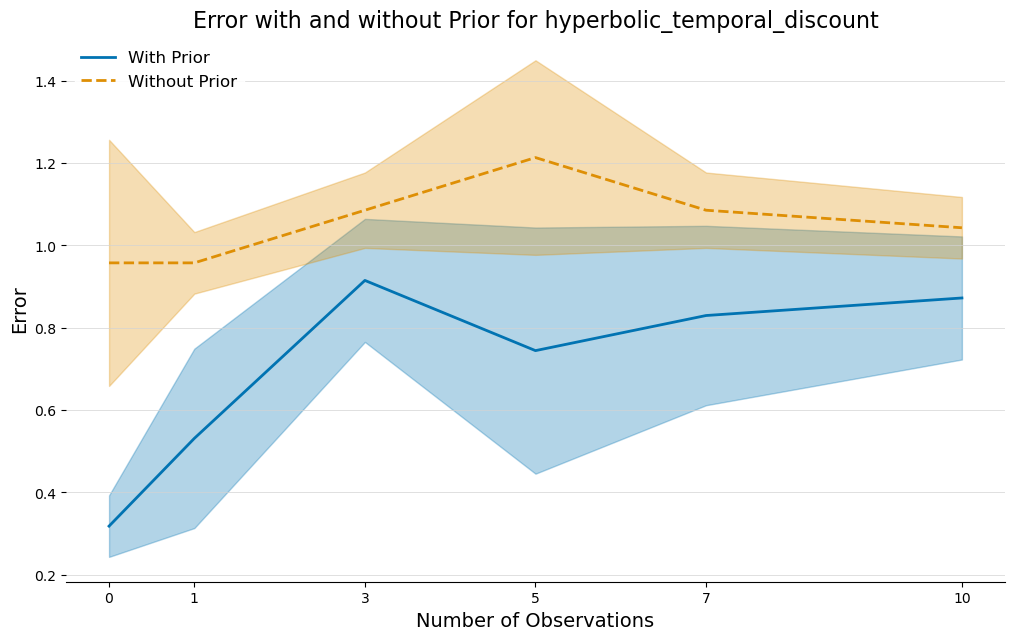

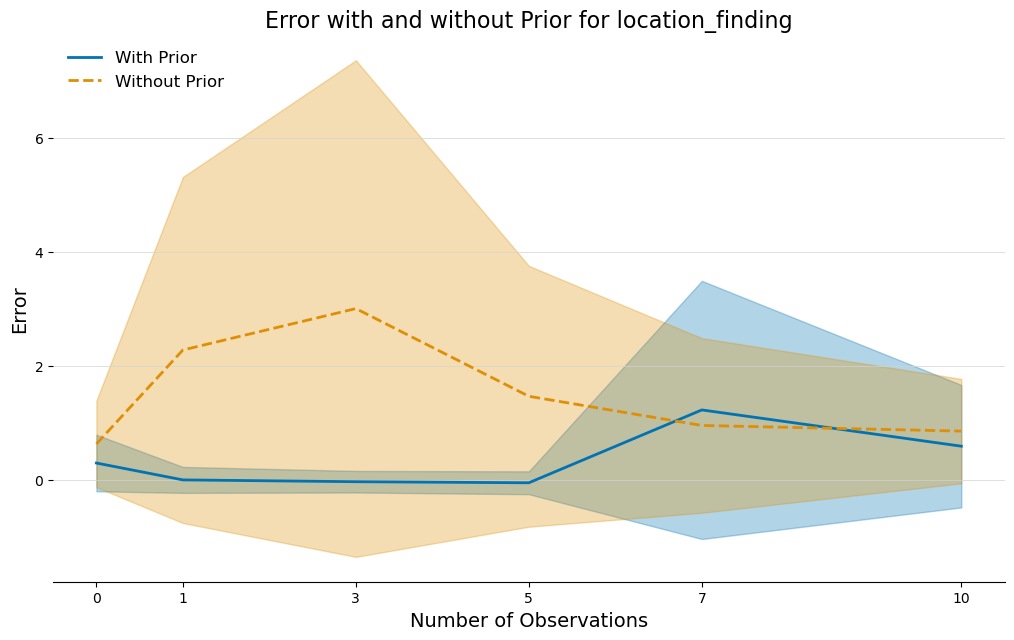

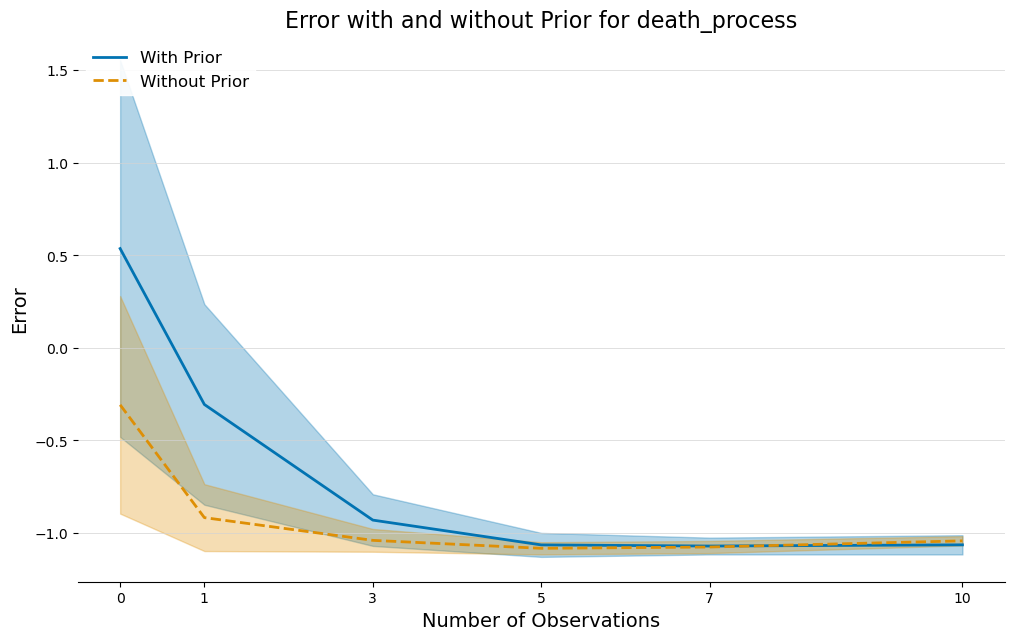

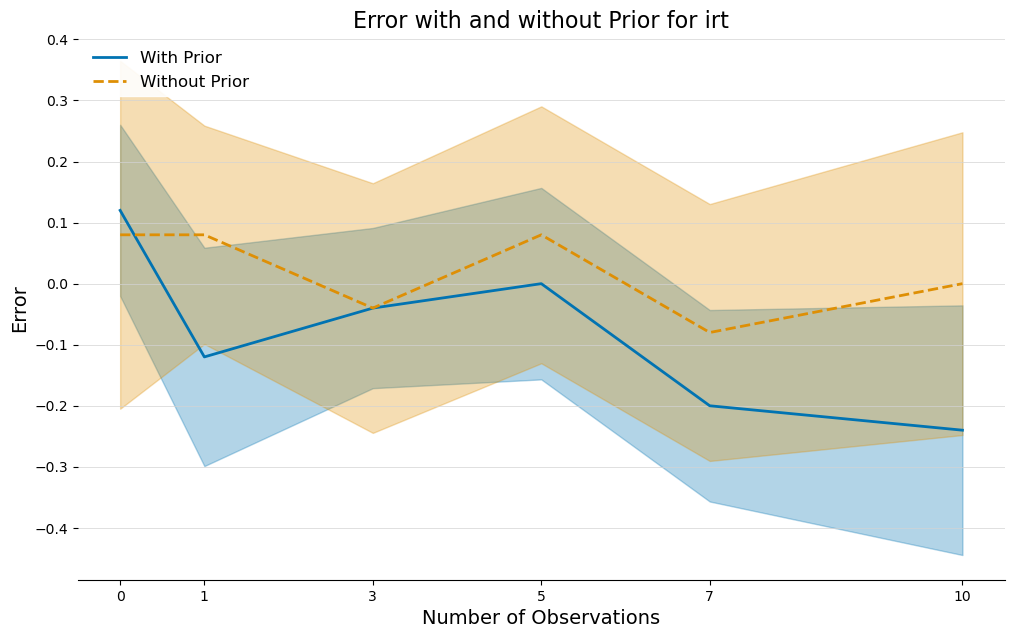

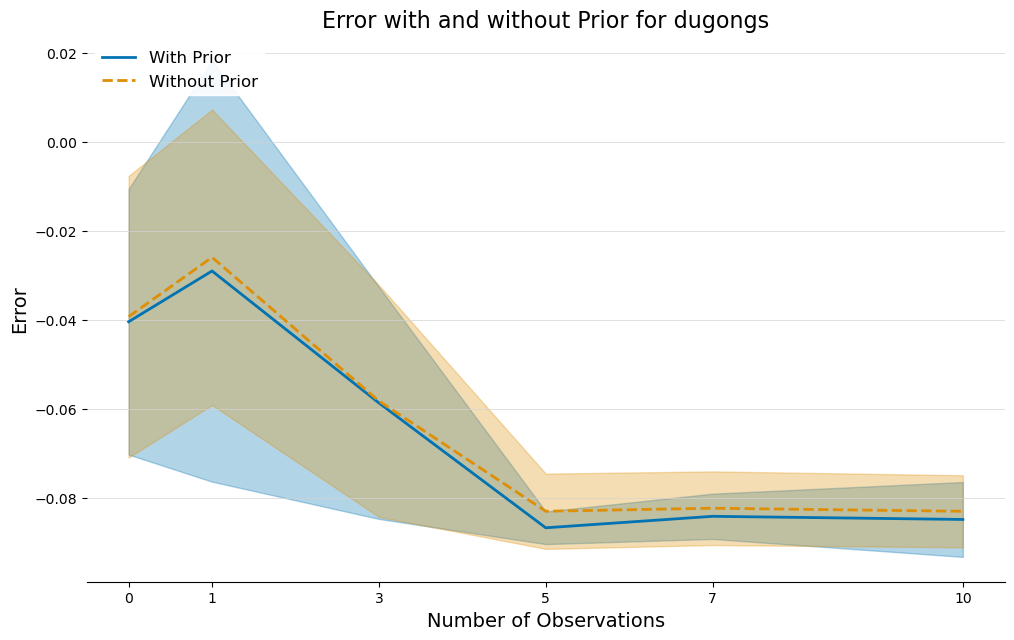

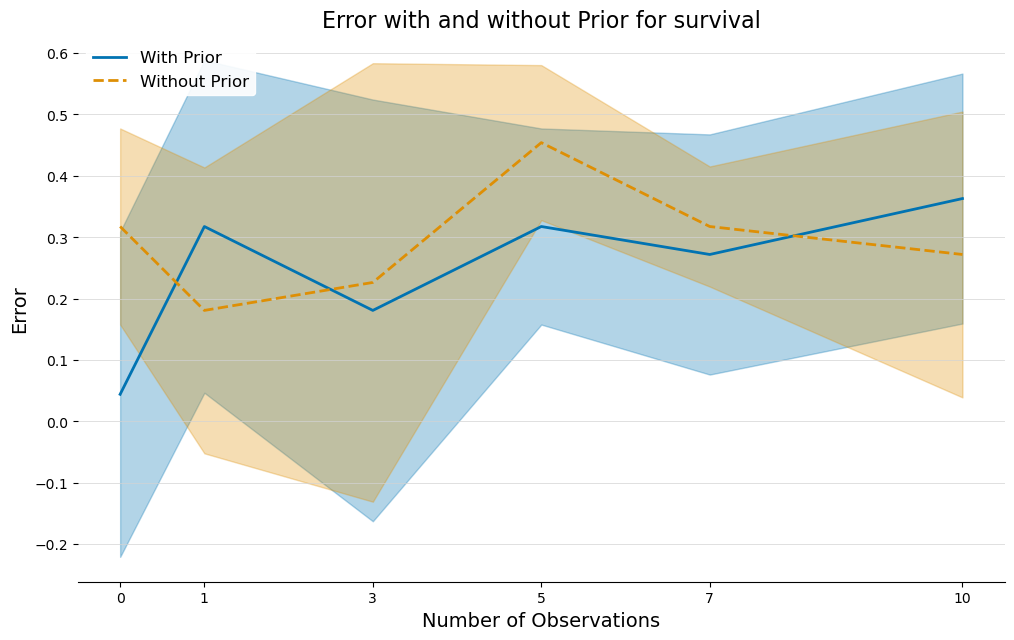

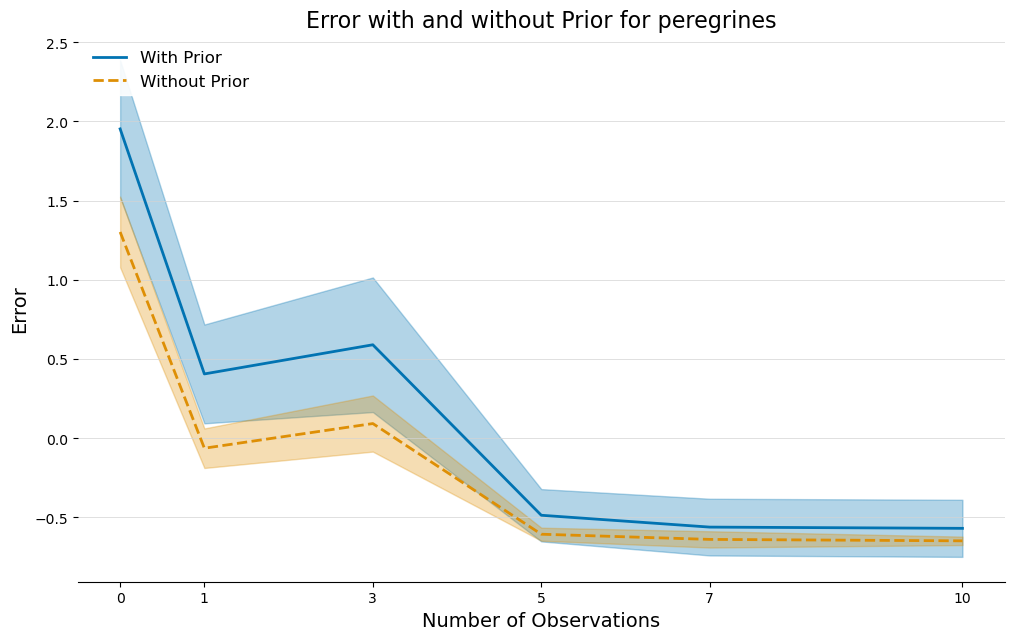

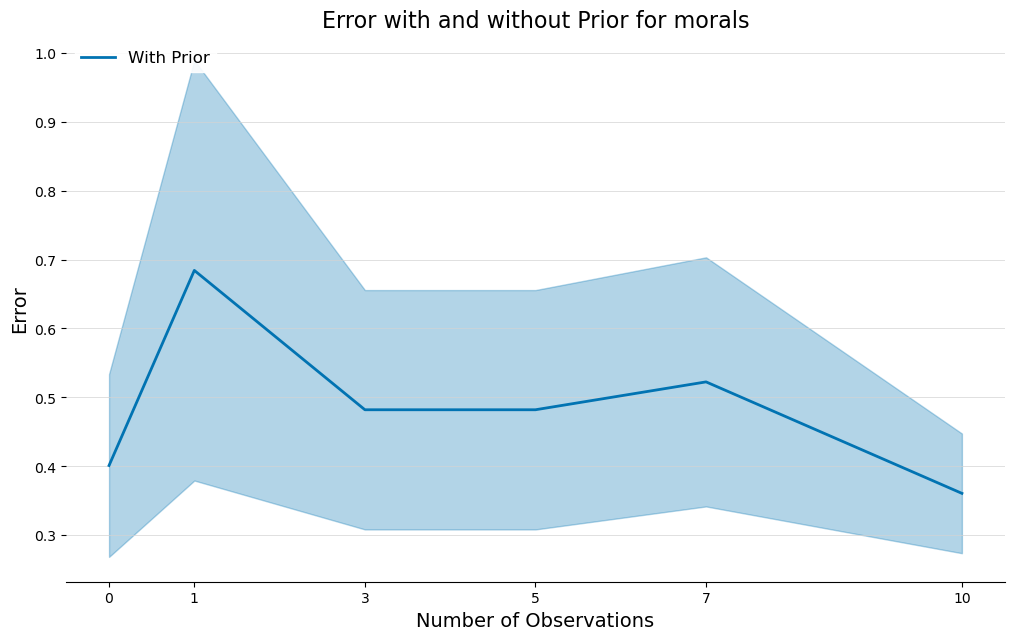

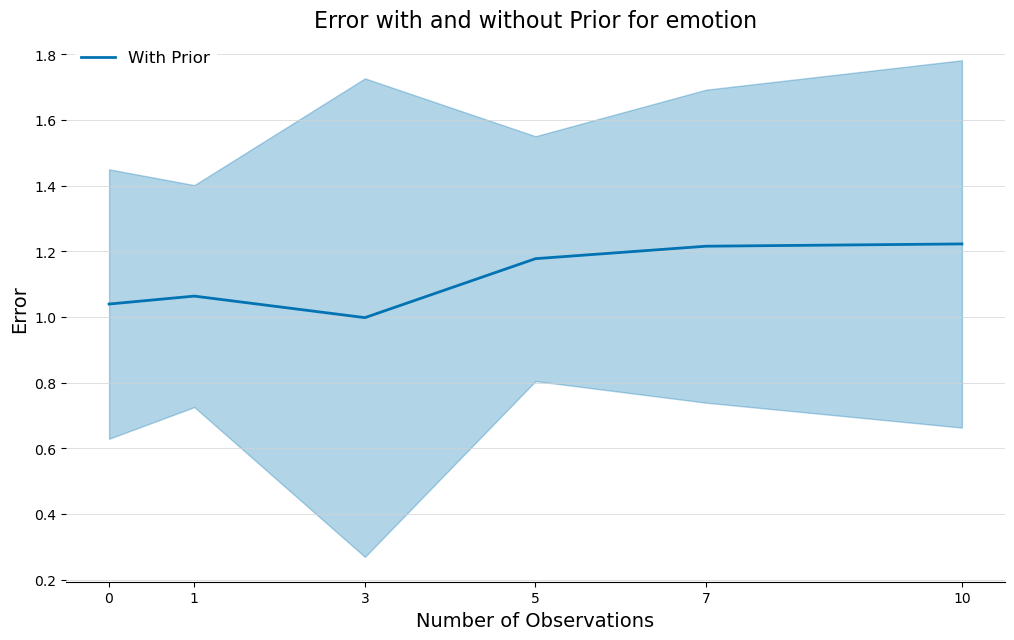

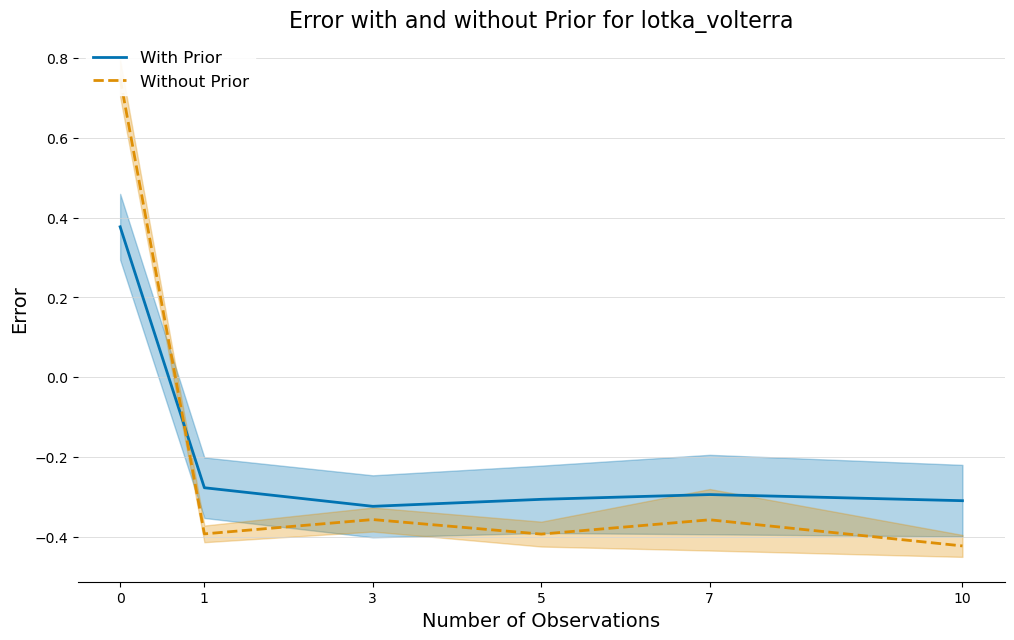

In [72]:
import os
import json
import numpy as np
import pandas as pd
import boxing_gym.envs.location_finding
import boxing_gym.envs.hyperbolic_temporal_discount
import boxing_gym.envs.death_process
import boxing_gym.envs.irt
import boxing_gym.envs.survival_analysis
import boxing_gym.envs.peregrines
import boxing_gym.envs.dugongs
import boxing_gym.envs.lotka_volterra
import boxing_gym.envs.moral_machines
import boxing_gym.envs.emotion
from plot_utils import plot_lines

results_dir = "/sailhome/agam/boxing-gym/results/"
exp = "oed"
model = 'gpt-4o'
seeds = [1, 2, 3, 4, 5]
goal = "direct"
exp_list = [0, 1, 3, 5, 7, 10]

environments = [
    "hyperbolic_temporal_discount",
    "location_finding",
    "death_process",
    "irt",
    "dugongs",
    "survival",
    "peregrines",
    "morals",
    "emotion",
    "lotka_volterra"
]

nametoenv = {    
    "location_finding": boxing_gym.envs.location_finding.Signal,
    "hyperbolic_temporal_discount": boxing_gym.envs.hyperbolic_temporal_discount.TemporalDiscount,
    "death_process": boxing_gym.envs.death_process.DeathProcess,
    "irt": boxing_gym.envs.irt.IRT,
    "survival": boxing_gym.envs.survival_analysis.SurvivalAnalysis,
    "dugongs": boxing_gym.envs.dugongs.Dugongs,
    "peregrines": boxing_gym.envs.peregrines.Peregrines,
    "morals": boxing_gym.envs.moral_machines.MoralMachine,
    "emotion": boxing_gym.envs.emotion.EmotionFromOutcome,
    "lotka_volterra": boxing_gym.envs.lotka_volterra.LotkaVolterra,
}

nameenvtogoal = {
    ("hyperbolic_temporal_discount", "direct"): boxing_gym.envs.hyperbolic_temporal_discount.DirectGoal,
    ("location_finding", "direct"): boxing_gym.envs.location_finding.DirectGoal,
    ("death_process", "direct"): boxing_gym.envs.death_process.DirectDeath,
    ("irt", "direct"): boxing_gym.envs.irt.DirectCorrectness,
    ("survival", "direct"): boxing_gym.envs.survival_analysis.DirectGoal,
    ("dugongs", "direct"): boxing_gym.envs.dugongs.DirectGoal,
    ("peregrines", "direct"): boxing_gym.envs.peregrines.DirectGoal,
    ("emotion", "direct"): boxing_gym.envs.emotion.DirectEmotionPrediction,
    ("morals", "direct"): boxing_gym.envs.moral_machines.DirectPrediction,
    ("lotka_volterra", "direct"): boxing_gym.envs.lotka_volterra.DirectGoal,
}

def process_environment(env, goal, model, exp, seeds, results_dir):
    print(f"\nProcessing environment: {env}")
    
    environ = nametoenv[env]()
    goaln = nameenvtogoal[(env, goal)](environ)
    try:
        norm_mu = goaln.norm_mu
        norm_sigma = goaln.norm_sigma
    except:
        norm_mu = 0
        norm_sigma = 1
    
    print(f"norm_mu: {norm_mu}, norm_sigma: {norm_sigma}")
    
    files = [os.path.join(results_dir, env, f"{goal}_{model}_{exp}_True_{seed}.json") for seed in seeds]
    files_no_prior = [os.path.join(results_dir, env, f"{goal}_{model}_{exp}_False_{seed}.json") for seed in seeds]
    
    data = []
    for file in files:
        if not os.path.exists(file):
            print(f"  File not found: {file}")
            continue
        try:
            with open(file, "r") as f:
                data.append(json.load(f))
        except Exception as e:
            print(f"  Error loading {file}: {e}")
    
    data_no_prior = []
    for file in files_no_prior:
        if not os.path.exists(file):
            print(f"  File not found: {file}")
            continue
        try:
            with open(file, "r") as f:
                data_no_prior.append(json.load(f))
        except Exception as e:
            print(f"  Error loading {file}: {e}")
    
    errs, stds = [], []
    for d in data:
        errs.append([])
        stds.append([])
        for r in d['data']['results']: 
            errs[-1].append(r[0][0])
            stds[-1].append(r[0][1])
    
    errs_no_prior, stds_no_prior = [], []
    for d in data_no_prior:
        errs_no_prior.append([])
        stds_no_prior.append([])
        for r in d['data']['results']: 
            errs_no_prior[-1].append(r[0][0])
            stds_no_prior[-1].append(r[0][1])
    
    errs = np.array(errs)
    stds = np.array(stds)
    errs_no_prior = np.array(errs_no_prior)
    stds_no_prior = np.array(stds_no_prior)
    
    if env == "location_finding" and "direct" in goal:
        errs = np.clip(errs, 0, 500)
        errs_no_prior = np.clip(errs_no_prior, 0, 500)
    
    errs = (errs - norm_mu) / norm_sigma
    errs_no_prior = (errs_no_prior - norm_mu) / norm_sigma
    
    if env == "hyperbolic_temporal_discount" and "direct" in goal:
        errs = 1 - errs
        errs_no_prior = 1 - errs_no_prior
    elif env == "survival":
        errs = 1 - errs
        errs_no_prior = 1 - errs_no_prior
    elif env == "morals":
        print("  Applying 1-minus transformation for morals")
        errs = 1 - errs
    
    mean_score = np.mean(errs, axis=0) if len(errs) > 0 else np.array([])
    ci_95 = 1.96 * np.std(errs, axis=0) / np.sqrt(len(errs)) if len(errs) > 0 else np.array([])
    
    mean_score_no_prior = None
    ci_95_no_prior = None
    if len(errs_no_prior) > 0:
        mean_score_no_prior = np.mean(errs_no_prior, axis=0)
        ci_95_no_prior = 1.96 * np.std(errs_no_prior, axis=0) / np.sqrt(len(errs_no_prior))
    
    try:
        save_path = os.path.join('./plots', f"error_{env}_{goal}_{model}_{exp}_oed.png")
        plot_lines(
            exp_list,
            mean_score, ci_95, 
            mean_score_no_prior, ci_95_no_prior, 
            "With Prior", "Without Prior", 
            "Number of Observations", "Error", 
            f"Error with and without Prior for {env}", 
            save_path
        )
        print(f"  Plot saved to {save_path}")
    except Exception as e:
        print(f"  Error creating plot: {e}")
    
    rows = []
    
    def safe_get(arr, idx):
        if arr is None or len(arr) <= idx:
            return None
        return arr[idx]
    
    for obs_idx in exp_list:
        if mean_score is not None:
            pos = min(exp_list.index(obs_idx), len(mean_score)-1) if obs_idx in exp_list and len(mean_score) > 0 else None
            
            if pos is not None and pos < len(mean_score):
                rows.append({
                    'Environment': env,
                    'Prior': True,
                    'Obs_Index': obs_idx,
                    'Mean_Error': mean_score[pos],
                    'CI_95': ci_95[pos] if ci_95 is not None and pos < len(ci_95) else None
                })
            else:
                rows.append({
                    'Environment': env,
                    'Prior': True,
                    'Obs_Index': obs_idx,
                    'Mean_Error': None,
                    'CI_95': None
                })
    
    for obs_idx in exp_list:
        if mean_score_no_prior is not None:
            pos = min(exp_list.index(obs_idx), len(mean_score_no_prior)-1) if obs_idx in exp_list and len(mean_score_no_prior) > 0 else None
            
            if pos is not None and pos < len(mean_score_no_prior):
                rows.append({
                    'Environment': env,
                    'Prior': False,
                    'Obs_Index': obs_idx,
                    'Mean_Error': mean_score_no_prior[pos],
                    'CI_95': ci_95_no_prior[pos] if ci_95_no_prior is not None and pos < len(ci_95_no_prior) else None
                })
            else:
                rows.append({
                    'Environment': env,
                    'Prior': False,
                    'Obs_Index': obs_idx,
                    'Mean_Error': None,
                    'CI_95': None
                })
    
    return rows

def main():
    os.makedirs('./plots', exist_ok=True)
    os.makedirs('./results', exist_ok=True)
    
    all_rows = []
    for env in environments:
        try:
            env_rows = process_environment(env, goal, model, exp, seeds, results_dir)
            all_rows.extend(env_rows)
        except Exception as e:
            print(f"Error processing environment {env}: {e}")
            for obs_idx in exp_list:
                for prior in [True, False]:
                    all_rows.append({
                        'Environment': env,
                        'Prior': prior,
                        'Obs_Index': obs_idx,
                        'Mean_Error': None,
                        'CI_95': None
                    })
    
    df = pd.DataFrame(all_rows)
    
    csv_path = os.path.join('./results', f"{model}_{exp}_{goal}_errors_by_obs.csv")
    df.to_csv(csv_path, index=False)
    print(f"\nResults saved to {csv_path}")
    
    wide_df = df.pivot_table(
        index=['Environment', 'Prior'],
        columns='Obs_Index',
        values=['Mean_Error', 'CI_95']
    ).reset_index()
    
    wide_df.columns = [f"{col[0]}_{col[1]}" if isinstance(col, tuple) else col for col in wide_df.columns]
    
    wide_csv_path = os.path.join('./results', f"{model}_{exp}_{goal}_errors_by_obs_wide.csv")
    wide_df.to_csv(wide_csv_path, index=False)
    print(f"Wide format results saved to {wide_csv_path}")
    
    print("\nProcessing complete!")
    print(f"Total environments processed: {len(environments)}")
    print(f"Total data points: {len(df)}")

if __name__ == "__main__":
    main()

In [74]:
import os
import json
import numpy as np
import pandas as pd
import boxing_gym.envs.location_finding
import boxing_gym.envs.hyperbolic_temporal_discount
import boxing_gym.envs.death_process
import boxing_gym.envs.irt
import boxing_gym.envs.survival_analysis
import boxing_gym.envs.peregrines
import boxing_gym.envs.dugongs
import boxing_gym.envs.lotka_volterra
import boxing_gym.envs.moral_machines
import boxing_gym.envs.emotion
from plot_utils import plot_lines

results_dir = "/sailhome/agam/boxing-gym/results/"
exp = "oed"
model = 'qwen2.5-7b-instruct' #'gpt-4o'
seeds = [1, 2, 3, 4, 5]
goal = "direct"
exp_list = [0, 1, 3, 5, 7, 10]

environments = [
    "hyperbolic_temporal_discount",
    "location_finding",
    "death_process",
    "irt",
    "dugongs",
    "survival",
    "peregrines",
    "morals",
    "emotion",
]

nametoenv = {    
    "location_finding": boxing_gym.envs.location_finding.Signal,
    "hyperbolic_temporal_discount": boxing_gym.envs.hyperbolic_temporal_discount.TemporalDiscount,
    "death_process": boxing_gym.envs.death_process.DeathProcess,
    "irt": boxing_gym.envs.irt.IRT,
    "survival": boxing_gym.envs.survival_analysis.SurvivalAnalysis,
    "dugongs": boxing_gym.envs.dugongs.Dugongs,
    "peregrines": boxing_gym.envs.peregrines.Peregrines,
    "morals": boxing_gym.envs.moral_machines.MoralMachine,
    "emotion": boxing_gym.envs.emotion.EmotionFromOutcome,
    "lotka_volterra": boxing_gym.envs.lotka_volterra.LotkaVolterra,
}

nameenvtogoal = {
    ("hyperbolic_temporal_discount", "direct"): boxing_gym.envs.hyperbolic_temporal_discount.DirectGoal,
    ("location_finding", "direct"): boxing_gym.envs.location_finding.DirectGoal,
    ("death_process", "direct"): boxing_gym.envs.death_process.DirectDeath,
    ("irt", "direct"): boxing_gym.envs.irt.DirectCorrectness,
    ("survival", "direct"): boxing_gym.envs.survival_analysis.DirectGoal,
    ("dugongs", "direct"): boxing_gym.envs.dugongs.DirectGoal,
    ("peregrines", "direct"): boxing_gym.envs.peregrines.DirectGoal,
    ("emotion", "direct"): boxing_gym.envs.emotion.DirectEmotionPrediction,
    ("morals", "direct"): boxing_gym.envs.moral_machines.DirectPrediction,
    ("lotka_volterra", "direct"): boxing_gym.envs.lotka_volterra.DirectGoal,
}

def process_environment_eig(env, goal, model, exp, seeds, results_dir):
    print(f"\nProcessing EIG for environment: {env}")
    
    environ = nametoenv[env]()
    goaln = nameenvtogoal[(env, goal)](environ)
    try:
        norm_mu = goaln.norm_mu
        norm_sigma = goaln.norm_sigma
    except:
        norm_mu = 0
        norm_sigma = 1
    
    print(f"norm_mu: {norm_mu}, norm_sigma: {norm_sigma}")
    
    files = [os.path.join(results_dir, env, f"{goal}_{model}_{exp}_True_{seed}.json") for seed in seeds]
    files_no_prior = [os.path.join(results_dir, env, f"{goal}_{model}_{exp}_False_{seed}.json") for seed in seeds]
    regret_files = [os.path.join(results_dir, env, f"regret_{goal}_{model}_{exp}_True_{seed}.json") for seed in seeds]
    regret_files_no_prior = [os.path.join(results_dir, env, f"regret_{goal}_{model}_{exp}_False_{seed}.json") for seed in seeds]
    
    data = []
    for file in files:
        if not os.path.exists(file):
            print(f"  File not found: {file}")
            continue
        try:
            with open(file, "r") as f:
                data.append(json.load(f))
        except Exception as e:
            print(f"  Error loading {file}: {e}")
    
    data_no_prior = []
    for file in files_no_prior:
        if not os.path.exists(file):
            print(f"  File not found: {file}")
            continue
        try:
            with open(file, "r") as f:
                data_no_prior.append(json.load(f))
        except Exception as e:
            print(f"  Error loading {file}: {e}")
    
    regrets = []
    for file in regret_files:
        if not os.path.exists(file):
            print(f"  File not found: {file}")
            continue
        try:
            with open(file, "r") as f:
                regrets.append(json.load(f))
        except Exception as e:
            print(f"  Error loading {file}: {e}")
    
    regrets_no_prior = []
    for file in regret_files_no_prior:
        if not os.path.exists(file):
            print(f"  File not found: {file}")
            continue
        try:
            with open(file, "r") as f:
                regrets_no_prior.append(json.load(f))
        except Exception as e:
            print(f"  Error loading {file}: {e}")
    
    successes = [d['data']['successes'] for d in data] if data else []
    successes_no_prior = [d['data']['successes'] for d in data_no_prior] if data_no_prior else []
    
    eigs, eigs_no_prior, eig_regrets, eigregrets_no_prior = [], [], [], []
    
    if env == "irt":
        for a, d in enumerate(regrets):
            eigs.append([])
            eig_regrets.append([])
            for b, r in enumerate(d['eigs']):
                if successes[a][b]:
                    eigs[-1].append(r)
                    eig_regrets[-1].append(d['eigs_regret'][b])
            eigs[-1] = eigs[-1][:9]
            eig_regrets[-1] = eig_regrets[-1][:9]
        
        for a, d in enumerate(regrets_no_prior):
            eigs_no_prior.append([])
            eigregrets_no_prior.append([])
            for b, r in enumerate(d['eigs']):
                if successes_no_prior[a][b]:
                    eigs_no_prior[-1].append(r)
                    eigregrets_no_prior[-1].append(d['eigs_regret'][b])
            eigs_no_prior[-1] = eigs_no_prior[-1][:9]
            eigregrets_no_prior[-1] = eigregrets_no_prior[-1][:9]
    else:
        try:
            eigs = [np.array(d['eigs']) for d in regrets]
            eigs_no_prior = [np.array(d['eigs']) for d in regrets_no_prior]
        except:
            eigs = []
            eigs_no_prior = []
        
        try:
            eig_regrets = [np.array(d['eigs_regret']) for d in regrets]
            eigregrets_no_prior = [np.array(d['eigs_regret']) for d in regrets_no_prior]
        except:
            eig_regrets = []
            eigregrets_no_prior = []
    
    if env == "location_finding" and "direct" in goal:
        if eig_regrets:
            eig_regrets = np.clip(eig_regrets, 0, 50000)
            eig_regrets = eig_regrets / 1000
        
        if eigregrets_no_prior:
            eigregrets_no_prior = np.clip(eigregrets_no_prior, 0, 50000)
            eigregrets_no_prior = eigregrets_no_prior / 1000
    
    if env == "irt":
        observation_nums = list(range(9))
    else:
        observation_nums = list(range(10))
    
    eigs = np.array(eigs)
    eigs_no_prior = np.array(eigs_no_prior)
    eig_regrets = np.array(eig_regrets)
    eigregrets_no_prior = np.array(eigregrets_no_prior)
    
    mean_eigs = None
    ci_95_eigs = None
    mean_eigs_no_prior = None
    ci_95_eigs_no_prior = None
    
    if len(eigs) > 0:
        mean_eigs = np.mean(eigs, axis=0)
        ci_95_eigs = 1.96 * np.std(eigs, axis=0) / np.sqrt(len(eigs))
        
        if len(eigs_no_prior) > 0:
            mean_eigs_no_prior = np.mean(eigs_no_prior, axis=0)
            ci_95_eigs_no_prior = 1.96 * np.std(eigs_no_prior, axis=0) / np.sqrt(len(eigs_no_prior))
    
    mean_regret = None
    ci_95_regret = None
    mean_regret_no_prior = None
    ci_95_regret_no_prior = None
    
    if len(eig_regrets) > 0:
        mean_regret = np.mean(eig_regrets, axis=0)
        ci_95_regret = 1.96 * np.std(eig_regrets, axis=0) / np.sqrt(len(eig_regrets))
        
        if len(eigregrets_no_prior) > 0:
            mean_regret_no_prior = np.mean(eigregrets_no_prior, axis=0)
            ci_95_regret_no_prior = 1.96 * np.std(eigregrets_no_prior, axis=0) / np.sqrt(len(eigregrets_no_prior))
    
    try:
        if mean_eigs is not None:
            save_path = os.path.join('./plots', f"{env}_{goal}_{model}_{exp}_oed_eigs.png")
            plot_lines(
                observation_nums, 
                mean_eigs, ci_95_eigs, 
                mean_eigs_no_prior, ci_95_eigs_no_prior, 
                "With Prior", "Without Prior", 
                "Number of Observations", "Expected IG", 
                f"Expected IG with and without Prior for {env}", 
                save_path
            )
            print(f"  EIG plot saved to {save_path}")
        
        if mean_regret is not None:
            save_path = os.path.join('./plots', f"{env}_{goal}_{model}_{exp}_oed_regret.png")
            plot_lines(
                observation_nums, 
                mean_regret, ci_95_regret, 
                mean_regret_no_prior, ci_95_regret_no_prior, 
                "With Prior", "Without Prior", 
                "Number of Observations", "Expected IG Regret", 
                f"Expected IG Regret with and without Prior for {env}", 
                save_path
            )
            print(f"  Regret plot saved to {save_path}")
    except Exception as e:
        print(f"  Error creating plots: {e}")
    
    rows = []
    
    def safe_get(arr, idx):
        if arr is None or len(arr) <= idx:
            return None
        return float(arr[idx])
    
    for obs_idx in exp_list:
        pos = exp_list.index(obs_idx)
        
        if mean_eigs is not None:
            actual_pos = min(pos, len(mean_eigs)-1) if len(mean_eigs) > 0 else None
            
            if actual_pos is not None and actual_pos < len(mean_eigs):
                rows.append({
                    'Environment': env,
                    'Metric': 'EIG',
                    'Prior': True,
                    'Obs_Index': obs_idx,
                    'Mean_Value': safe_get(mean_eigs, actual_pos),
                    'CI_95': safe_get(ci_95_eigs, actual_pos) if ci_95_eigs is not None else None
                })
            else:
                rows.append({
                    'Environment': env,
                    'Metric': 'EIG',
                    'Prior': True,
                    'Obs_Index': obs_idx,
                    'Mean_Value': None,
                    'CI_95': None
                })
        
        if mean_eigs_no_prior is not None:
            actual_pos = min(pos, len(mean_eigs_no_prior)-1) if len(mean_eigs_no_prior) > 0 else None
            
            if actual_pos is not None and actual_pos < len(mean_eigs_no_prior):
                rows.append({
                    'Environment': env,
                    'Metric': 'EIG',
                    'Prior': False,
                    'Obs_Index': obs_idx,
                    'Mean_Value': safe_get(mean_eigs_no_prior, actual_pos),
                    'CI_95': safe_get(ci_95_eigs_no_prior, actual_pos) if ci_95_eigs_no_prior is not None else None
                })
            else:
                rows.append({
                    'Environment': env,
                    'Metric': 'EIG',
                    'Prior': False,
                    'Obs_Index': obs_idx,
                    'Mean_Value': None,
                    'CI_95': None
                })
        
        if mean_regret is not None:
            actual_pos = min(pos, len(mean_regret)-1) if len(mean_regret) > 0 else None
            
            if actual_pos is not None and actual_pos < len(mean_regret):
                rows.append({
                    'Environment': env,
                    'Metric': 'EIGRegret',
                    'Prior': True,
                    'Obs_Index': obs_idx,
                    'Mean_Value': safe_get(mean_regret, actual_pos),
                    'CI_95': safe_get(ci_95_regret, actual_pos) if ci_95_regret is not None else None
                })
            else:
                rows.append({
                    'Environment': env,
                    'Metric': 'EIGRegret',
                    'Prior': True,
                    'Obs_Index': obs_idx,
                    'Mean_Value': None,
                    'CI_95': None
                })
        
        if mean_regret_no_prior is not None:
            actual_pos = min(pos, len(mean_regret_no_prior)-1) if len(mean_regret_no_prior) > 0 else None
            
            if actual_pos is not None and actual_pos < len(mean_regret_no_prior):
                rows.append({
                    'Environment': env,
                    'Metric': 'EIGRegret',
                    'Prior': False,
                    'Obs_Index': obs_idx,
                    'Mean_Value': safe_get(mean_regret_no_prior, actual_pos),
                    'CI_95': safe_get(ci_95_regret_no_prior, actual_pos) if ci_95_regret_no_prior is not None else None
                })
            else:
                rows.append({
                    'Environment': env,
                    'Metric': 'EIGRegret',
                    'Prior': False,
                    'Obs_Index': obs_idx,
                    'Mean_Value': None,
                    'CI_95': None
                })
    
    if mean_eigs is not None:
        mean_eig_all = float(np.mean(mean_eigs))
        ci_95_eig_all = float(np.mean(ci_95_eigs)) if ci_95_eigs is not None else None
        
        rows.append({
            'Environment': env,
            'Metric': 'MeanEIG',
            'Prior': True,
            'Obs_Index': -1,
            'Mean_Value': mean_eig_all,
            'CI_95': ci_95_eig_all
        })
    
    if mean_eigs_no_prior is not None:
        mean_eig_all_no_prior = float(np.mean(mean_eigs_no_prior))
        ci_95_eig_all_no_prior = float(np.mean(ci_95_eigs_no_prior)) if ci_95_eigs_no_prior is not None else None
        
        rows.append({
            'Environment': env,
            'Metric': 'MeanEIG',
            'Prior': False,
            'Obs_Index': -1,
            'Mean_Value': mean_eig_all_no_prior,
            'CI_95': ci_95_eig_all_no_prior
        })
    
    if mean_regret is not None:
        mean_regret_all = float(np.mean(mean_regret))
        ci_95_regret_all = float(np.mean(ci_95_regret)) if ci_95_regret is not None else None
        
        rows.append({
            'Environment': env,
            'Metric': 'MeanEIGRegret',
            'Prior': True,
            'Obs_Index': -1,
            'Mean_Value': mean_regret_all,
            'CI_95': ci_95_regret_all
        })
    
    if mean_regret_no_prior is not None:
        mean_regret_all_no_prior = float(np.mean(mean_regret_no_prior))
        ci_95_regret_all_no_prior = float(np.mean(ci_95_regret_no_prior)) if ci_95_regret_no_prior is not None else None
        
        rows.append({
            'Environment': env,
            'Metric': 'MeanEIGRegret',
            'Prior': False,
            'Obs_Index': -1,
            'Mean_Value': mean_regret_all_no_prior,
            'CI_95': ci_95_regret_all_no_prior
        })
    
    return rows

def main():
    os.makedirs('./plots', exist_ok=True)
    os.makedirs('./results', exist_ok=True)
    
    all_rows = []
    for env in environments:
        try:
            env_rows = process_environment_eig(env, goal, model, exp, seeds, results_dir)
            all_rows.extend(env_rows)
        except Exception as e:
            print(f"Error processing EIG for environment {env}: {e}")
    
    df = pd.DataFrame(all_rows)
    
    csv_path = os.path.join('./results', f"{model}_{exp}_{goal}_eig_metrics.csv")
    df.to_csv(csv_path, index=False)
    print(f"\nEIG metrics saved to {csv_path}")
    
    eig_df = df[df['Metric'] == 'EIG'].copy()
    eig_regret_df = df[df['Metric'] == 'EIGRegret'].copy()
    mean_eig_df = df[df['Metric'] == 'MeanEIG'].copy()
    mean_eig_regret_df = df[df['Metric'] == 'MeanEIGRegret'].copy()
    
    eig_csv_path = os.path.join('./results', f"{model}_{exp}_{goal}_eig_by_obs.csv")
    eig_regret_csv_path = os.path.join('./results', f"{model}_{exp}_{goal}_eig_regret_by_obs.csv")
    mean_eig_csv_path = os.path.join('./results', f"{model}_{exp}_{goal}_mean_eig.csv")
    mean_eig_regret_csv_path = os.path.join('./results', f"{model}_{exp}_{goal}_mean_eig_regret.csv")
    
    eig_df.to_csv(eig_csv_path, index=False)
    eig_regret_df.to_csv(eig_regret_csv_path, index=False)
    mean_eig_df.to_csv(mean_eig_csv_path, index=False)
    mean_eig_regret_df.to_csv(mean_eig_regret_csv_path, index=False)
    
    print(f"EIG by observation saved to {eig_csv_path}")
    print(f"EIG regret by observation saved to {eig_regret_csv_path}")
    print(f"Mean EIG summary saved to {mean_eig_csv_path}")
    print(f"Mean EIG regret summary saved to {mean_eig_regret_csv_path}")
    
    wide_eig_df = eig_df.pivot_table(
        index=['Environment', 'Prior'],
        columns='Obs_Index',
        values=['Mean_Value', 'CI_95']
    ).reset_index()
    
    wide_eig_df.columns = [f"{col[0]}_{col[1]}" if isinstance(col, tuple) else col for col in wide_eig_df.columns]
    
    wide_eig_regret_df = eig_regret_df.pivot_table(
        index=['Environment', 'Prior'],
        columns='Obs_Index',
        values=['Mean_Value', 'CI_95']
    ).reset_index()
    
    wide_eig_regret_df.columns = [f"{col[0]}_{col[1]}" if isinstance(col, tuple) else col for col in wide_eig_regret_df.columns]
    
    wide_eig_csv_path = os.path.join('./results', f"{model}_{exp}_{goal}_eig_by_obs_wide.csv")
    wide_eig_regret_csv_path = os.path.join('./results', f"{model}_{exp}_{goal}_eig_regret_by_obs_wide.csv")
    
    wide_eig_df.to_csv(wide_eig_csv_path, index=False)
    wide_eig_regret_df.to_csv(wide_eig_regret_csv_path, index=False)
    
    print(f"Wide format EIG by observation saved to {wide_eig_csv_path}")
    print(f"Wide format EIG regret by observation saved to {wide_eig_regret_csv_path}")
    
    print("\nProcessing complete!")
    print(f"Total environments processed: {len(environments)}")
    print(f"Total data points: {len(df)}")

if __name__ == "__main__":
    main()


Processing EIG for environment: hyperbolic_temporal_discount
norm_mu: 0.5, norm_sigma: 0.4692829610160591
  EIG plot saved to ./plots/hyperbolic_temporal_discount_direct_qwen2.5-32b-instruct_oed_oed_eigs.png
  Regret plot saved to ./plots/hyperbolic_temporal_discount_direct_qwen2.5-32b-instruct_oed_oed_regret.png

Processing EIG for environment: location_finding
norm_mu: 12.59, norm_sigma: 38.03
  EIG plot saved to ./plots/location_finding_direct_qwen2.5-32b-instruct_oed_oed_eigs.png
  Regret plot saved to ./plots/location_finding_direct_qwen2.5-32b-instruct_oed_oed_regret.png

Processing EIG for environment: death_process
norm_mu: 222.2998, norm_sigma: 189.76853880440774


Sampling: [alpha, beta, gamma, responses]


  EIG plot saved to ./plots/death_process_direct_qwen2.5-32b-instruct_oed_oed_eigs.png
  Regret plot saved to ./plots/death_process_direct_qwen2.5-32b-instruct_oed_oed_regret.png

Processing EIG for environment: irt
norm_mu: 0.5, norm_sigma: 0.5
  File not found: /sailhome/agam/boxing-gym/results/irt/regret_direct_qwen2.5-32b-instruct_oed_False_1.json
  File not found: /sailhome/agam/boxing-gym/results/irt/regret_direct_qwen2.5-32b-instruct_oed_False_2.json
  File not found: /sailhome/agam/boxing-gym/results/irt/regret_direct_qwen2.5-32b-instruct_oed_False_3.json
  File not found: /sailhome/agam/boxing-gym/results/irt/regret_direct_qwen2.5-32b-instruct_oed_False_4.json
  File not found: /sailhome/agam/boxing-gym/results/irt/regret_direct_qwen2.5-32b-instruct_oed_False_5.json
Error processing EIG for environment irt: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (5,) + inhomogeneous part.

Processing E

Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [death_outcome]
Sampling: [d